In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import json
from collections import defaultdict
# import plotly.graph_objects as go
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import nltk
from nltk.corpus import wordnet 
nltk.download('stopwords')
from nltk.corpus import stopwords
# import spacy

import time
import string


# from sklearn.

# MODELS
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

# EVALUATION METRICS and TOOLS
from sklearn.metrics import balanced_accuracy_score, classification_report, f1_score, precision_score, recall_score


# OTHER TOOLS
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import  HalvingGridSearchCV, RepeatedStratifiedKFold, cross_val_score, train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


# eli5
import eli5


from utils import main as utils, plots, preprocessing


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alhas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Needed functions

In [2]:
MODELS = ['LR', 'SVM', 'RF']
ITERATIONS = 1

In [3]:

with open("data/id_to_label.json", "r") as f:
    # Write the dictionary to the file in JSON format
    id_to_label = json.load(f)

In [4]:
def get_related_words(words):
    related_words = set(words)
    for word in words:
        for sset in wordnet.synsets(word):
            
            for hypernym in sset.hypernyms():
                [related_words.add(n) for n in hypernym.lemma_names()]
        
            for hyponym in sset.hyponyms():
                [related_words.add(n) for n in hyponym.lemma_names()]

    return related_words

In [5]:
def train_model(model,
                X_train, y_train,
                X_test, y_test, 
                **kwargs,
                # exclude, 
                # verbose=False
               ):
        
    if model == 'RF':
        clf = RandomForestClassifier(n_estimators=100)
    # pipe = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(max_iter=10000))  
    elif model == 'LR':
        clf = LogisticRegression(max_iter=10000)
    elif model == 'SVM':
        clf = svm.LinearSVC(C=1.0)
    elif model == 'KN':
        clf = make_pipeline(StandardScaler(with_mean=False),
             KNeighborsClassifier(n_neighbors=16))

    if kwargs.get('verbose'):
        print("#"*10, f"Training {clf.__class__.__name__}\n")

    
    vectorizer = TfidfVectorizer(
        sublinear_tf=True, 
        max_df=0.5, 
        min_df=5, 
        tokenizer=lambda doc: preprocessing.tokenize_data(doc, exclude=kwargs.get('exclude'), stopwords=kwargs.get('stopwords')),
        # stop_words="english"
    )
                    
    
    X_train_trasformed = vectorizer.fit_transform(X_train)

    clf.fit(X_train_trasformed, y_train)
    
    X_test_transformed = vectorizer.transform(X_test)
    
    score = clf.score(X_test_transformed, y_test)
    pred = clf.predict(X_test_transformed)
    
    
    feature_names = vectorizer.get_feature_names_out()
                    
    # if verbose:
    if kwargs.get('verbose'):
        print("#"*10, score)
    
    
    return clf, pred, score, X_train_trasformed, X_test_transformed, feature_names

In [6]:
def run(models=['LR', 'RF', 'SVM', 'KN'], **kwargs):
    # for cat in categories:
# for cat in [224, 226]:
    # print(cat)
    
    exact = kwargs.get('exact') and kwargs.get('specific_cat')
    iteration = kwargs.get('iteration')
    id= kwargs.get('id')
    df_performance = kwargs.get('df_performance')
    kwargs['exact'] = exact
    
    # Load data
    df, X_train, X_test, y_train, y_test, target_names = utils.load_dataset('data/en_data.csv',
                                                                                           target_label='ocms',
                                                                                           **kwargs)
    # print(df[df.index.duplicated(keep=False)].textrecord)


    
    if kwargs.get('verbose'):
        sns.histplot([f'{id_to_label[i]} ({i})' for i in df['ocms']])
        plt.xticks(rotation=90)
        plt.show()
            
        
    dfs = []
    
    # duplicate_indices = y_test.index.duplicated() # Check for duplicate indices in y_test
    # if any(duplicate_indices):
    #     _y_test = y_test[~duplicate_indices]

    # print(y_test.loc[y_test.duplicated(), :])
    # y_test.drop_duplicates(inplace=True)

    df_out = df.loc[y_test.index]
    reports = defaultdict(list)
    # df_out = X_test.copy()
    # print(X_test)
    # print('DUPLICATED', any(df_out.index.duplicated()))
    # print(df_out['ocms'].value_counts(), len(y_test))
    top_indicators = defaultdict(list)
    cms = []
    # Run models
    for model in models:
        print('#'*10, kwargs.get('cat'), model, '\n')
            
        clf, pred, score, X_train_transformed, X_test_transformed, feature_names = train_model(model, 
                                            X_train, y_train,
                                            X_test, y_test,
                                            **kwargs
                                            # kwargs.get('exclude'), kwargs.get('stopwords'),
                                            # verbose=True
                                       )
        
        y_pred  = pd.DataFrame(pred)

        df_out[f'predicted_{model}'] = pred
        # report = classification_report(y_test, pred, digits=3, output_dict=True)
                
        macro_precision = precision_score(y_test, pred, average='macro')
        macro_recall = recall_score(y_test, pred, average='macro')
        macro_f1 = f1_score(y_test, pred, average='macro')
        reports[model] = [macro_precision, macro_recall, macro_f1]
        
        if iteration == 0:
            df_performance.loc[f'{id}_{model}'] = reports[model]
            # df_performance.loc[f'{id}_recall'] = macro_recall
            # df_performance.loc[f'{id}_f1'] = macro_f1
            
            # chosen_cats = kwargs.get('chosen_categories')
            # if chosen_cats:
            #     # df_performance.loc[f'{i}_{"_".join([str(i) for i in chosen_cats])}'] = report
            #     # print(report)
            #     df_performance.loc[f'{i}_{"_".join([str(i) for i in chosen_cats])}'] = report
            # else:
            #     cat = kwargs.get('specific_cat')
            #     exact = kwargs.get('exact')
            #     # df_performance.loc[f'{i}_{cat}_{"exact" if exact else "not_exact"}'] = report
            #     df_performance.loc[f'{i}_{cat}_{"exact" if exact else "not_exact"}'] = report
                
        if kwargs.get('verbose'):
            report = classification_report(y_test, pred, digits = 3)
            print(report)

        cms.append([clf, pred, y_test])
        cm = plots.make_cm(clf, pred, y_test, target_names, to_labels=id_to_label)
        culture_plot = plots.plot_per_culture(df_out, model, top_k=10)
        
        # print(eli5.show_weights(clf, top=10, target_names=target_names))

        if model == 'RF':
            # plots.plot_feature_effects(clf, X_train, fn, tn)  
            indicators = plots.plot_feature_importance(clf.feature_importances_, feature_names, 'RF')    
            # plot_feature_importance(clf, feature_names, target_names,  top_k=5)    
        else:
            # explainer = shap.Explainer(svm.LinearSVC(C=1.0).fit(X_train_transformed, y_train))
            # shap_values = explainer(X_train_transformed)
            # shap.plots.bar(shap_values)
            # indicators = plot_feature_effects(clf, X_train_transformed, feature_names, target_names, to_labels=id_to_label)#, top_k=10)
            if clf.coef_.shape[0] > 1:
                indicators = plots.plot_feature_effects_detailed(clf, X_train_transformed, feature_names, target_names, to_labels=id_to_label)#, top_k=5) 
            else:
                indicators = plot_feature_effects(abs(clf.coef_[0]), feature_names, 10)    
                
                
            #     # perm_importance = permutation_importance(clf, X_test_transformed.toarray(), y_test)
                
            #     # sorted_idx = perm_importance.importances_mean.argsort()
            #     # plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
            #     # plt.xlabel("Permutation Importance")
            #     # plt.show()
            #     indicators = plot_feature_effects(clf, X_train_transformed, feature_names, target_names, to_labels=id_to_label)#, top_k=10)
                
                # indicators = plot_feature_effects(clf.coef_[0], feature_names, )#, top_k=10)
        top_indicators[model] = indicators

    
    # cm = plots.make_cms(cms, target_names, to_labels=id_to_label, iteration=iteration)
    
    return df_out, top_indicators, reports

In [7]:
def get_common_indicators(top_indicators):
    # Get the list of arrays from the top_indicators values
    arrays = list(top_indicators.values())

    # Get the intersection of all arrays
    shared_elements = set(arrays[0]).intersection(*arrays)

    # Create a list to preserve the order of shared elements
    shared_elements_ordered = [x for x in arrays[0] if x in shared_elements]
    return shared_elements_ordered
    

In [8]:
def iterative_process(iterations=ITERATIONS, common_indicators=True, **kwargs):
    results = kwargs.get('results', defaultdict(dict))
    top_indicators = kwargs.get('top_indicators', set())
    
    reports = defaultdict(list)
    for i in range(iterations):
        print(f"Iteration {i+1}\nExclude: {top_indicators}\n")
        
    
        df, curr_indicators, report  = run(exclude=top_indicators, iteration=i,
                                  **kwargs)
        
        arrays = list(curr_indicators.values())
        
        ci = set(arrays[0]).intersection(*arrays)
        if common_indicators:
            top_indicators.update(ci)
        else:    
            top_indicators.update(set(arrays[0]).union(*arrays))

        results[i]['df'] = df
        results[i]['indicators'] = top_indicators
        results[i]['common_indicators'] = ci
        reports[i].append(report)
        results[i]['reports'] = report
                
    return results

In [9]:
def plot_performance(results, fig_path=''):
    fig = make_subplots(rows=1, cols=3,
                       subplot_titles=("Precision","Recall", "F1-score"))
    
    
    iterations = [i for i in range(1, ITERATIONS+1)]
    performance = defaultdict(list)
    for m in MODELS:
        # print(results.values())
        for i in range(ITERATIONS):
            performance[m].append(results[i]['reports'][m])
        fig.add_trace(go.Scatter(x=iterations, y=[p for p, _, _ in performance[m]], mode='lines+markers+text', textposition="top left", text=m), row=1, col=1)
        fig.add_trace(go.Scatter(x=iterations, y=[r for _, r, _ in performance[m]], mode='lines+markers+text', textposition="top center", text=m,), row=1, col=2)
        fig.add_trace(go.Scatter(x=iterations, y=[f for _, _, f in performance[m]], mode='lines+markers+text', textposition="middle center", text=m), row=1, col=3)
        
        # fig.add_trace(go.Scatter(x=iterations, y=f1_means[m], mode='lines+markers', name=m))
        # fig.add_trace(go.Scatter(x=iterations, y=[f1*0.01 for f1 in f1_means[m]], mode='text', name=m))
    fig.update_layout(height=400,
                                      
                    # title='Model Performance Metrics',
                    xaxis_title='Iteration',
                    yaxis_title='Score',
                     xaxis=dict(
                    tickmode='linear',
                    tickvals=iterations),
                    showlegend=False,
                    margin=dict(l=0, r=0, t=30, b=10),
                     )
    fig.show()
    fig.write_image(fig_path)
# plot_performance(results, fig_path='output/metric/224_226.png')

In [10]:
# df_performance = pd.DataFrame([], columns=MODELS)
df_performance = pd.DataFrame([], columns=['precision', 'recall', 'f1-score'])

In [13]:

def plot_feature_effects(coef, names, top=-1):
    fig, ax = plt.subplots(figsize=(10, 8))
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    ax.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()
    return names[::-1][0:top]

# Specific categories

### 224 and 226

for b in [True, False]:
    print('Balanced:', b)
    results = iterative_process(models=['LR', 'SVM', 'RF'], 
                                common_indicators=False,
                                chosen_categories=[224, 226],
                                # chosen_categories=[222, 220],
                                balanced=b,
                                verbose=True)

Iteration 1
Exclude: {'bear', 'fish', 'kill', 'beaver', 'reef', 'hunting', 'basket', 'animal', 'line', 'game', 'deer', 'buffalo', 'river', 'weir', 'fishing', 'stream', 'canoe', 'sea', 'hook', 'boat', 'meat', 'net', 'hunter', 'snare', 'dog', 'salmon', 'fisherman', 'water', 'catch', 'herd', 'hunt'}

(5750,) (5750,)
5750 documents - 2.57MB (training set)
2 categories


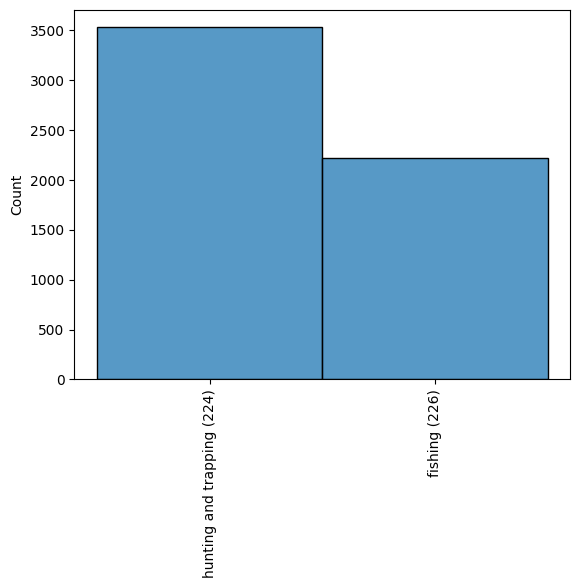

########## None LR 

########## Training LogisticRegression



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.8718840579710145
              precision    recall  f1-score   support

         224      0.854     0.956     0.902      1066
         226      0.912     0.736     0.814       659

    accuracy                          0.872      1725
   macro avg      0.883     0.846     0.858      1725
weighted avg      0.876     0.872     0.869      1725



C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:97: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



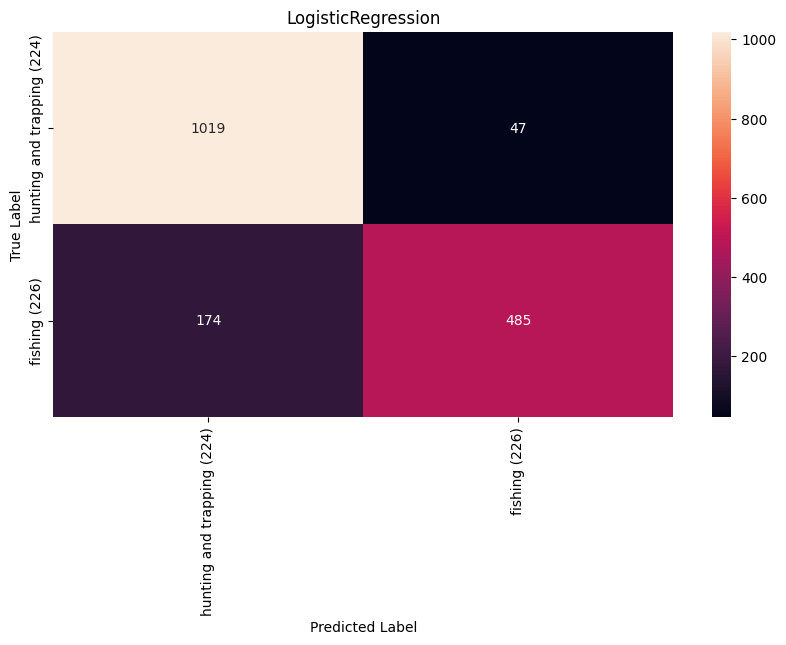

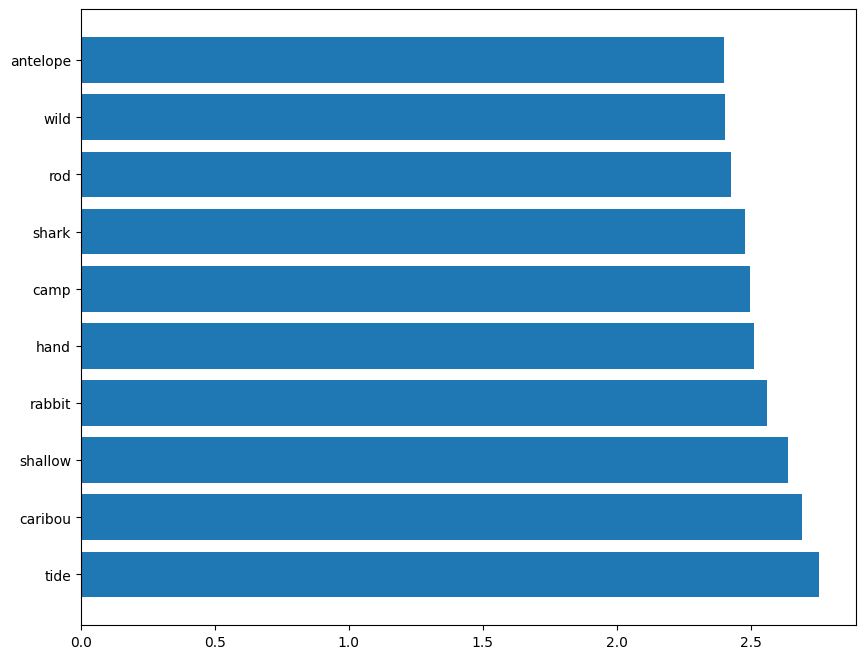

Iteration 2
Exclude: {'bear', 'shark', 'fish', 'kill', 'beaver', 'caribou', 'reef', 'hunting', 'antelope', 'line', 'game', 'deer', 'river', 'weir', 'fishing', 'stream', 'tide', 'fisherman', 'rod', 'wild', 'shallow', 'basket', 'animal', 'rabbit', 'buffalo', 'camp', 'canoe', 'sea', 'hook', 'boat', 'meat', 'net', 'hunter', 'snare', 'dog', 'salmon', 'water', 'catch', 'herd', 'hand', 'hunt'}

(5750,) (5750,)
5750 documents - 2.57MB (training set)
2 categories


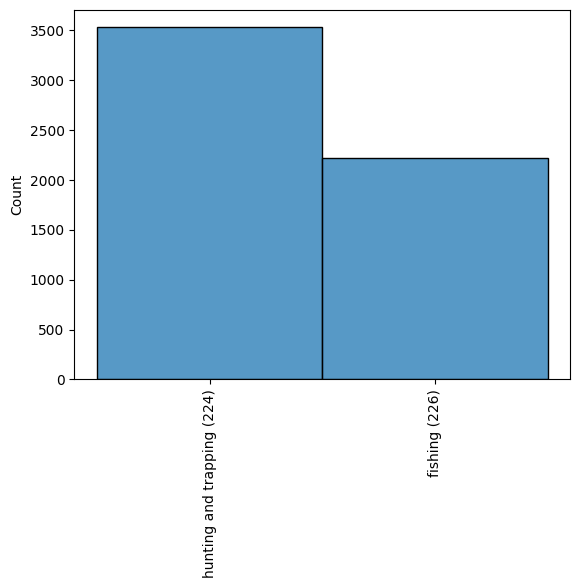

########## None LR 

########## Training LogisticRegression



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.8602898550724638
              precision    recall  f1-score   support

         224      0.841     0.954     0.894      1066
         226      0.905     0.709     0.795       659

    accuracy                          0.860      1725
   macro avg      0.873     0.831     0.844      1725
weighted avg      0.866     0.860     0.856      1725



C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:97: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



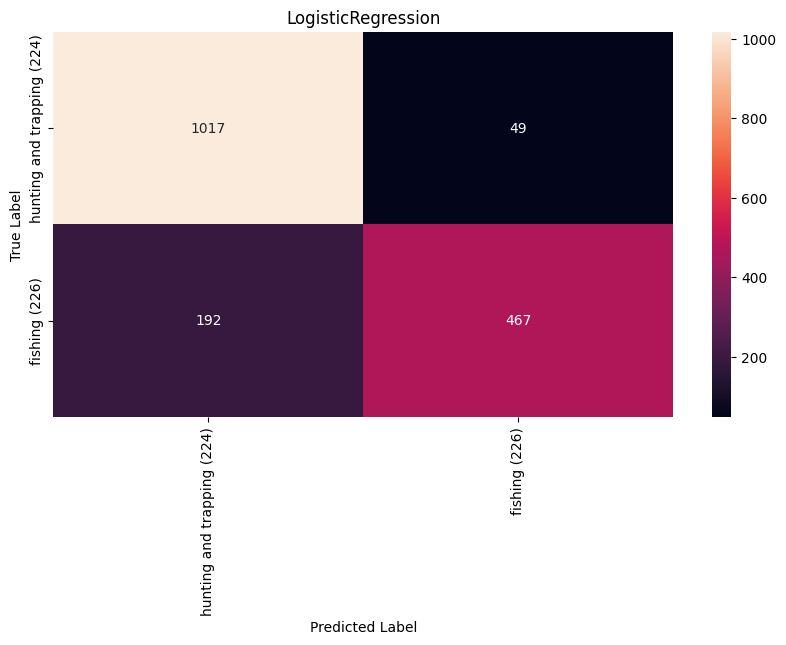

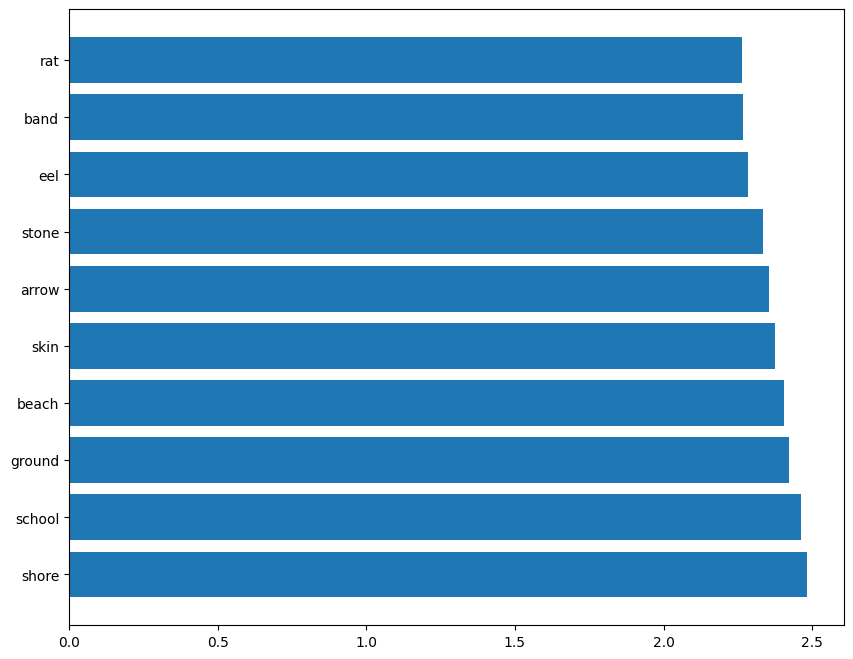

Iteration 3
Exclude: {'bear', 'shark', 'fish', 'kill', 'arrow', 'skin', 'beaver', 'caribou', 'reef', 'hunting', 'antelope', 'beach', 'line', 'game', 'deer', 'river', 'weir', 'fishing', 'stream', 'ground', 'eel', 'tide', 'fisherman', 'rod', 'school', 'shore', 'rat', 'wild', 'shallow', 'band', 'stone', 'basket', 'animal', 'rabbit', 'buffalo', 'camp', 'canoe', 'sea', 'hook', 'boat', 'meat', 'net', 'hunter', 'snare', 'dog', 'salmon', 'water', 'catch', 'herd', 'hand', 'hunt'}

(5750,) (5750,)
5750 documents - 2.57MB (training set)
2 categories


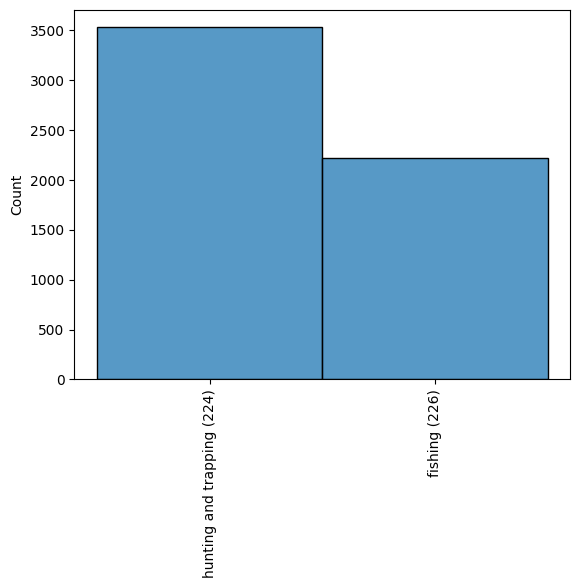

########## None LR 

########## Training LogisticRegression



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.8498550724637681
              precision    recall  f1-score   support

         224      0.832     0.948     0.886      1066
         226      0.892     0.690     0.778       659

    accuracy                          0.850      1725
   macro avg      0.862     0.819     0.832      1725
weighted avg      0.855     0.850     0.845      1725



C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:97: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



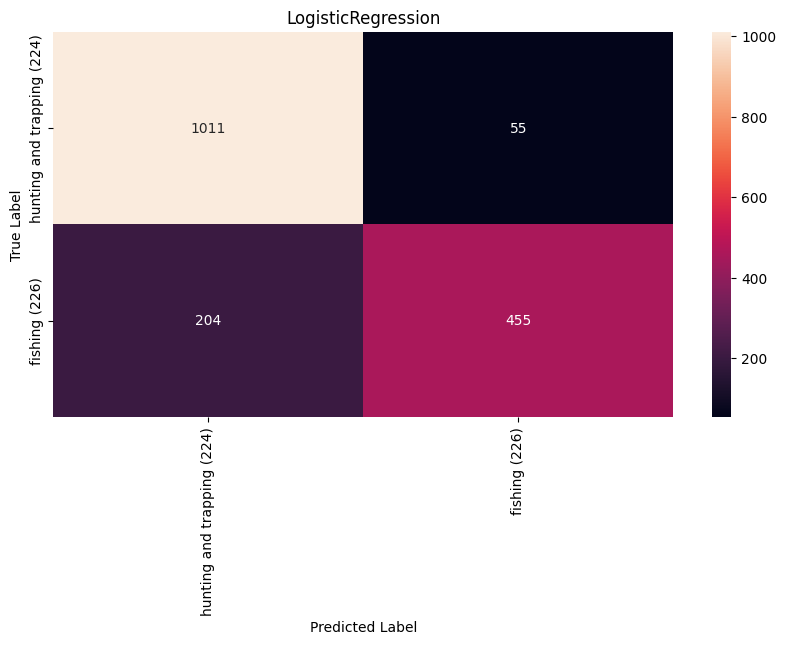

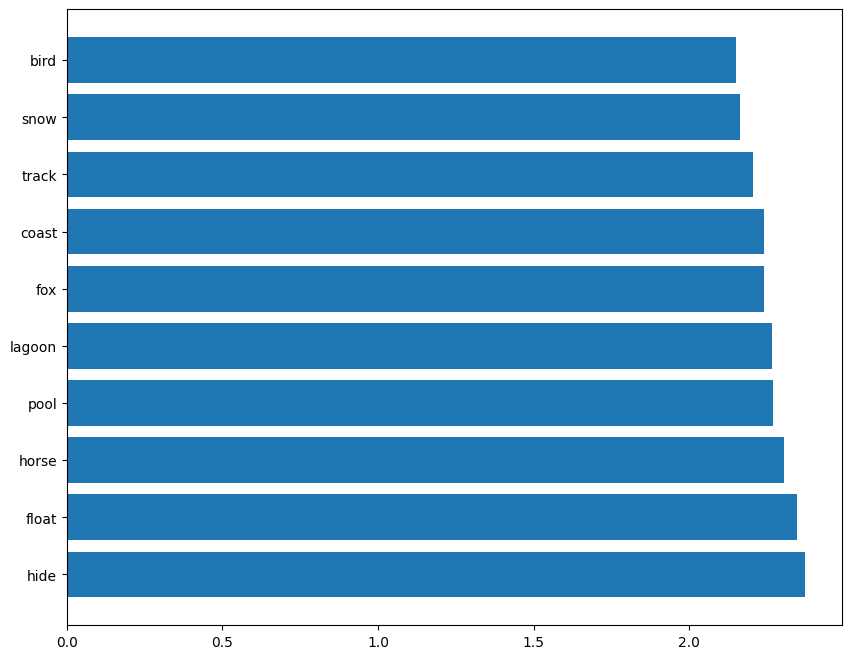

Iteration 4
Exclude: {'bear', 'shark', 'fish', 'kill', 'arrow', 'float', 'skin', 'beaver', 'caribou', 'reef', 'hunting', 'antelope', 'beach', 'hide', 'line', 'game', 'deer', 'bird', 'river', 'snow', 'weir', 'fishing', 'stream', 'ground', 'eel', 'fox', 'tide', 'coast', 'fisherman', 'rod', 'track', 'horse', 'school', 'shore', 'rat', 'pool', 'wild', 'shallow', 'band', 'stone', 'basket', 'animal', 'rabbit', 'buffalo', 'camp', 'canoe', 'sea', 'hook', 'boat', 'meat', 'net', 'hunter', 'snare', 'lagoon', 'dog', 'salmon', 'water', 'catch', 'herd', 'hand', 'hunt'}

(5750,) (5750,)
5750 documents - 2.57MB (training set)
2 categories


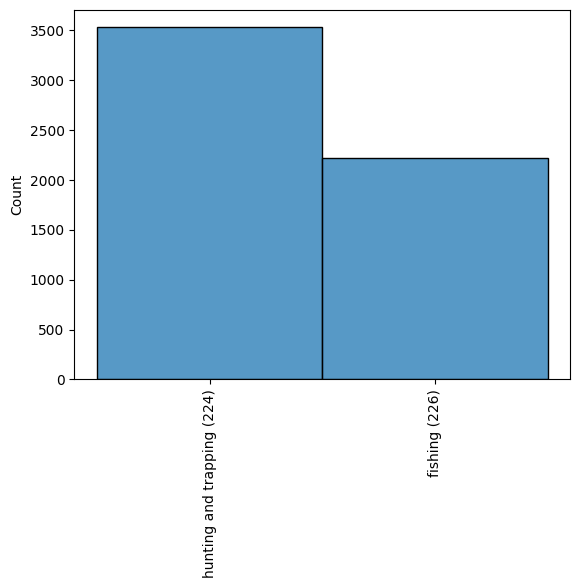

########## None LR 

########## Training LogisticRegression



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.8446376811594203
              precision    recall  f1-score   support

         224      0.829     0.944     0.882      1066
         226      0.883     0.684     0.771       659

    accuracy                          0.845      1725
   macro avg      0.856     0.814     0.827      1725
weighted avg      0.849     0.845     0.840      1725



C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:97: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



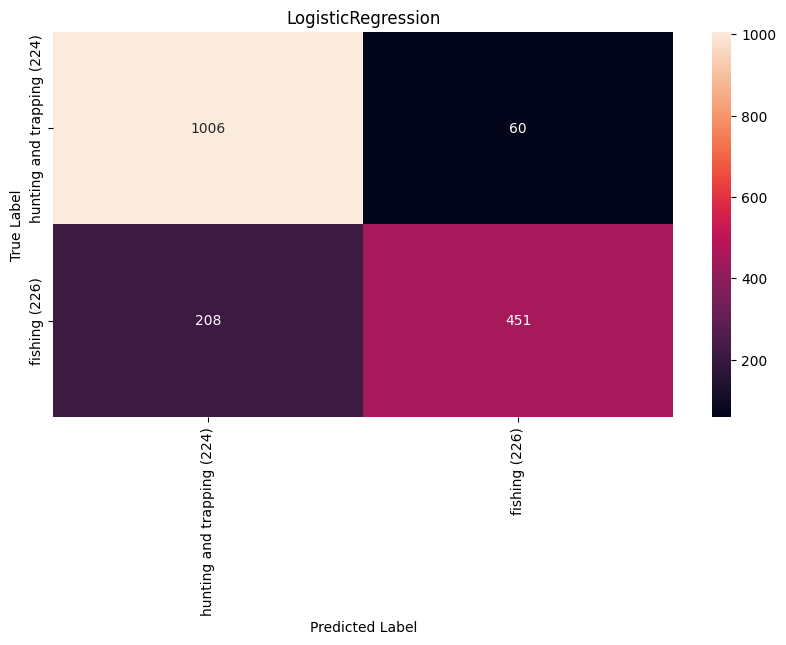

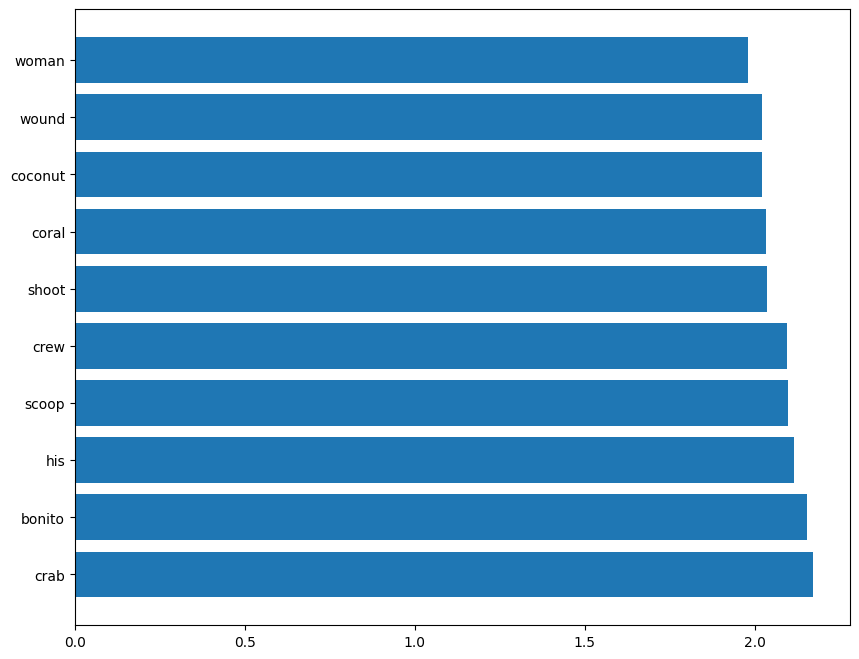

Iteration 5
Exclude: {'bear', 'shark', 'fish', 'kill', 'arrow', 'float', 'skin', 'beaver', 'caribou', 'reef', 'crew', 'hunting', 'antelope', 'beach', 'hide', 'line', 'game', 'deer', 'bird', 'river', 'snow', 'woman', 'weir', 'fishing', 'stream', 'ground', 'bonito', 'his', 'eel', 'fox', 'coconut', 'tide', 'coast', 'fisherman', 'rod', 'wound', 'track', 'horse', 'scoop', 'school', 'shore', 'rat', 'pool', 'crab', 'wild', 'shallow', 'band', 'stone', 'basket', 'animal', 'rabbit', 'buffalo', 'camp', 'canoe', 'sea', 'hook', 'boat', 'meat', 'net', 'hunter', 'snare', 'lagoon', 'dog', 'salmon', 'water', 'shoot', 'coral', 'catch', 'herd', 'hand', 'hunt'}

(5750,) (5750,)
5750 documents - 2.57MB (training set)
2 categories


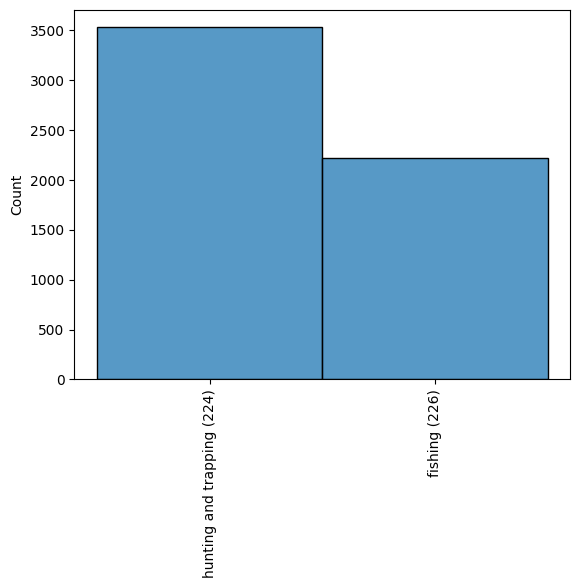

########## None LR 

########## Training LogisticRegression



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.8428985507246377
              precision    recall  f1-score   support

         224      0.828     0.941     0.881      1066
         226      0.877     0.684     0.769       659

    accuracy                          0.843      1725
   macro avg      0.853     0.813     0.825      1725
weighted avg      0.847     0.843     0.838      1725



C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:97: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



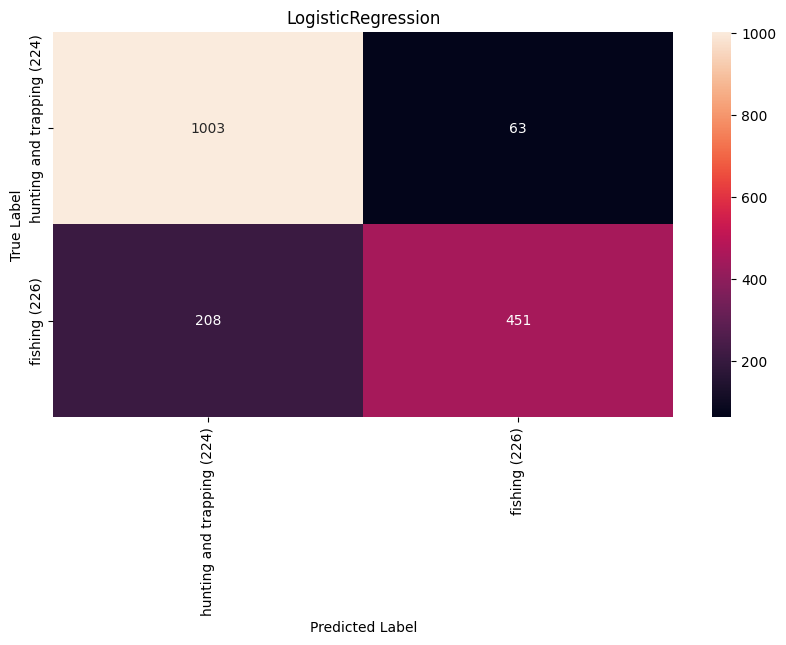

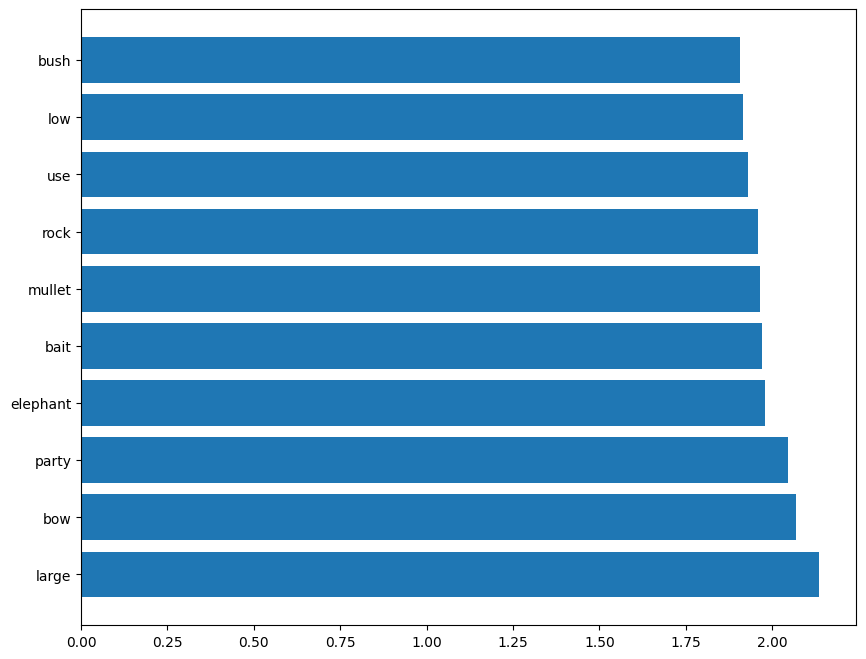

Iteration 6
Exclude: {'shark', 'float', 'kill', 'arrow', 'bush', 'hunting', 'beach', 'line', 'deer', 'use', 'river', 'snow', 'fishing', 'stream', 'ground', 'his', 'eel', 'fox', 'coast', 'fisherman', 'wound', 'rock', 'track', 'shore', 'hunt', 'large', 'pool', 'crab', 'wild', 'bow', 'stone', 'basket', 'rabbit', 'buffalo', 'camp', 'canoe', 'sea', 'meat', 'net', 'snare', 'dog', 'water', 'shoot', 'coral', 'hand', 'elephant', 'bear', 'fish', 'skin', 'beaver', 'reef', 'crew', 'antelope', 'hide', 'bird', 'game', 'woman', 'party', 'weir', 'bonito', 'coconut', 'tide', 'rod', 'horse', 'school', 'rat', 'mullet', 'shallow', 'low', 'band', 'animal', 'bait', 'scoop', 'lagoon', 'hook', 'boat', 'hunter', 'salmon', 'catch', 'herd', 'caribou'}

(5750,) (5750,)
5750 documents - 2.57MB (training set)
2 categories


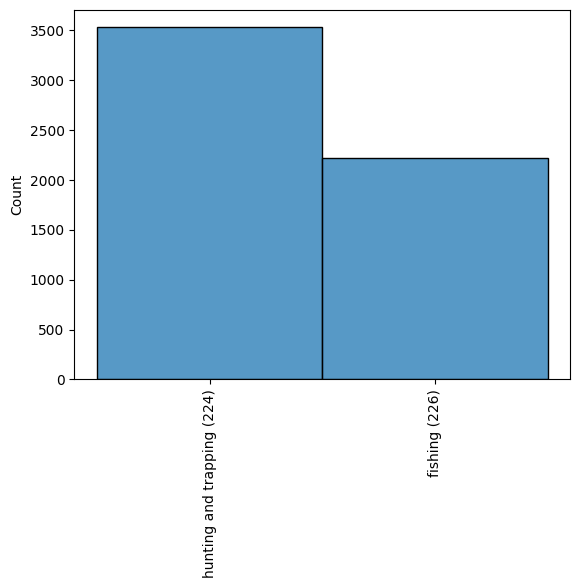

########## None LR 

########## Training LogisticRegression



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.8481159420289855
              precision    recall  f1-score   support

         224      0.827     0.953     0.886      1066
         226      0.899     0.678     0.773       659

    accuracy                          0.848      1725
   macro avg      0.863     0.816     0.830      1725
weighted avg      0.855     0.848     0.843      1725



C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:97: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



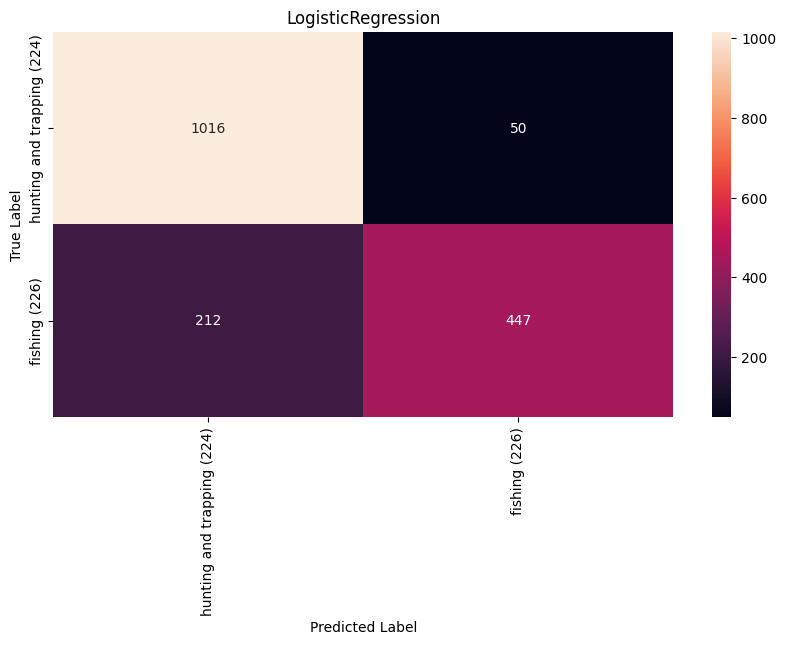

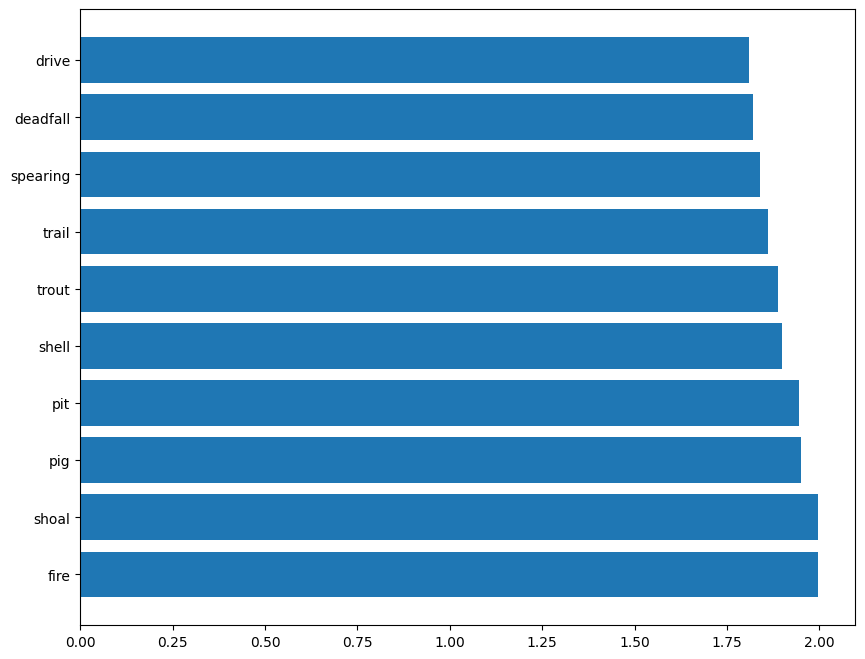

Iteration 7
Exclude: {'shark', 'float', 'kill', 'arrow', 'bush', 'hunting', 'beach', 'line', 'deer', 'use', 'river', 'snow', 'fishing', 'stream', 'ground', 'his', 'eel', 'fox', 'shoal', 'coast', 'fisherman', 'wound', 'rock', 'pit', 'track', 'trout', 'shore', 'hunt', 'spearing', 'large', 'pool', 'crab', 'wild', 'bow', 'stone', 'basket', 'deadfall', 'rabbit', 'buffalo', 'shell', 'camp', 'canoe', 'sea', 'meat', 'fire', 'net', 'snare', 'dog', 'water', 'shoot', 'coral', 'hand', 'elephant', 'bear', 'fish', 'skin', 'beaver', 'reef', 'crew', 'antelope', 'hide', 'bird', 'game', 'woman', 'party', 'weir', 'bonito', 'coconut', 'tide', 'rod', 'horse', 'pig', 'school', 'rat', 'mullet', 'trail', 'shallow', 'low', 'band', 'animal', 'bait', 'scoop', 'lagoon', 'hook', 'boat', 'hunter', 'salmon', 'catch', 'herd', 'drive', 'caribou'}

(5750,) (5750,)
5750 documents - 2.57MB (training set)
2 categories


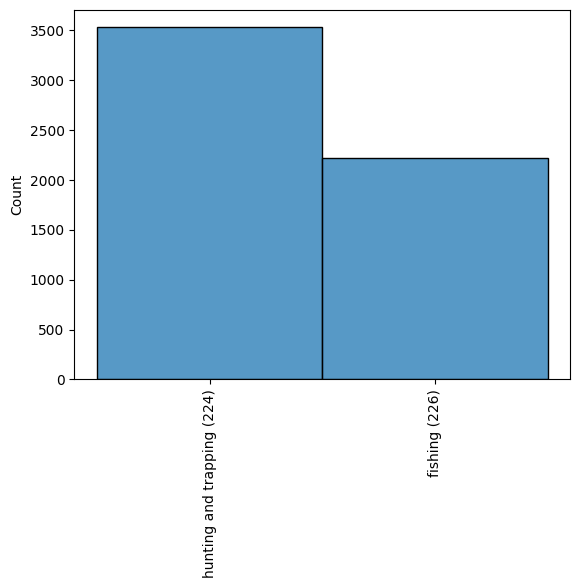

########## None LR 

########## Training LogisticRegression



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.8388405797101449
              precision    recall  f1-score   support

         224      0.820     0.947     0.879      1066
         226      0.886     0.663     0.759       659

    accuracy                          0.839      1725
   macro avg      0.853     0.805     0.819      1725
weighted avg      0.845     0.839     0.833      1725



C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:97: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



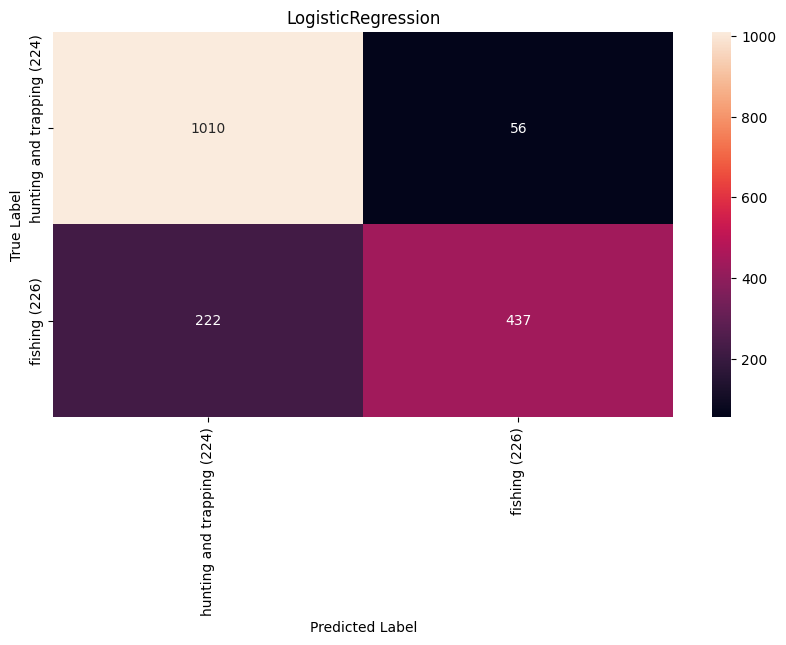

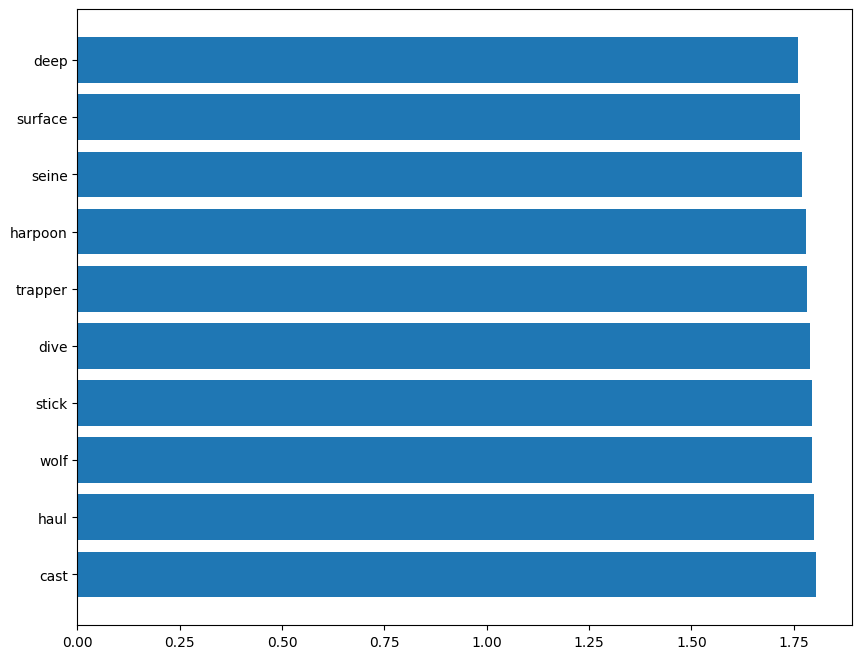

Iteration 8
Exclude: {'shark', 'float', 'kill', 'arrow', 'bush', 'haul', 'cast', 'hunting', 'beach', 'line', 'deer', 'use', 'river', 'snow', 'fishing', 'stream', 'ground', 'his', 'eel', 'fox', 'shoal', 'coast', 'fisherman', 'wound', 'rock', 'pit', 'track', 'seine', 'trout', 'shore', 'hunt', 'wolf', 'spearing', 'large', 'harpoon', 'pool', 'crab', 'wild', 'bow', 'stone', 'basket', 'deadfall', 'trapper', 'surface', 'rabbit', 'buffalo', 'shell', 'camp', 'canoe', 'sea', 'meat', 'fire', 'net', 'snare', 'dog', 'water', 'shoot', 'coral', 'hand', 'elephant', 'bear', 'fish', 'skin', 'beaver', 'reef', 'crew', 'antelope', 'stick', 'hide', 'bird', 'game', 'woman', 'party', 'deep', 'weir', 'bonito', 'dive', 'coconut', 'tide', 'rod', 'horse', 'pig', 'school', 'rat', 'mullet', 'trail', 'shallow', 'low', 'band', 'animal', 'bait', 'scoop', 'lagoon', 'hook', 'boat', 'hunter', 'salmon', 'catch', 'herd', 'drive', 'caribou'}

(5750,) (5750,)
5750 documents - 2.57MB (training set)
2 categories


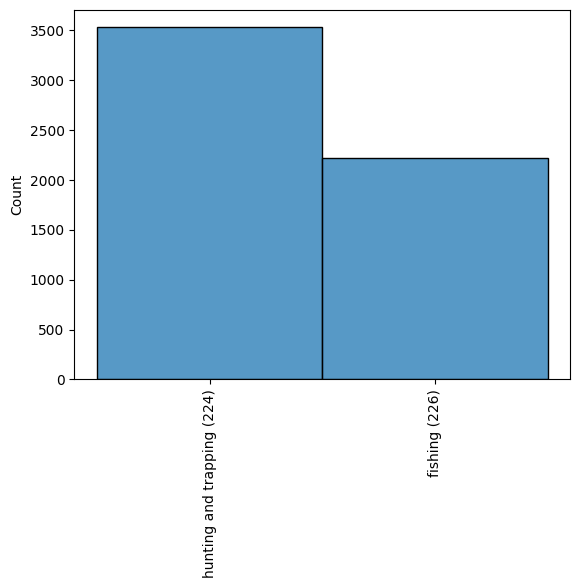

########## None LR 

########## Training LogisticRegression



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.8347826086956521
              precision    recall  f1-score   support

         224      0.817     0.944     0.876      1066
         226      0.879     0.659     0.753       659

    accuracy                          0.835      1725
   macro avg      0.848     0.801     0.814      1725
weighted avg      0.841     0.835     0.829      1725



C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:97: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



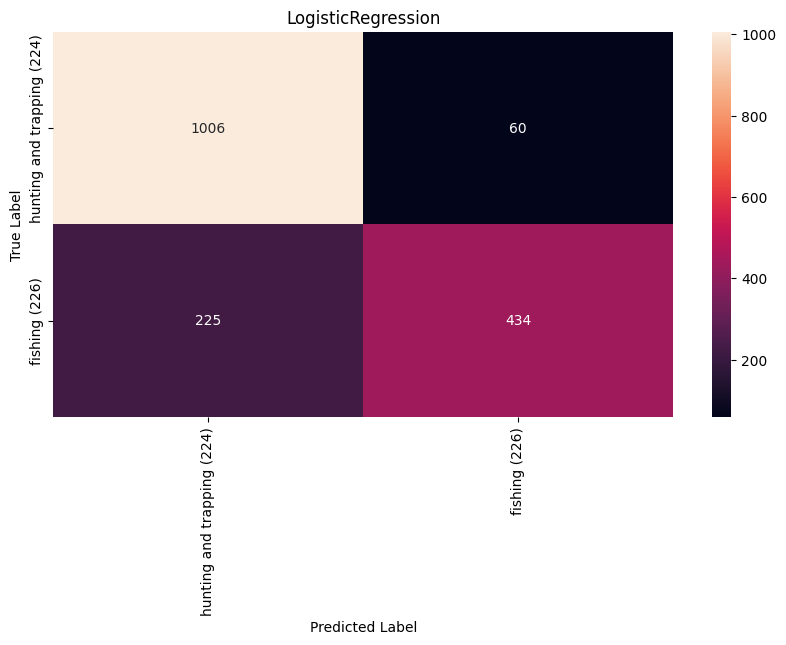

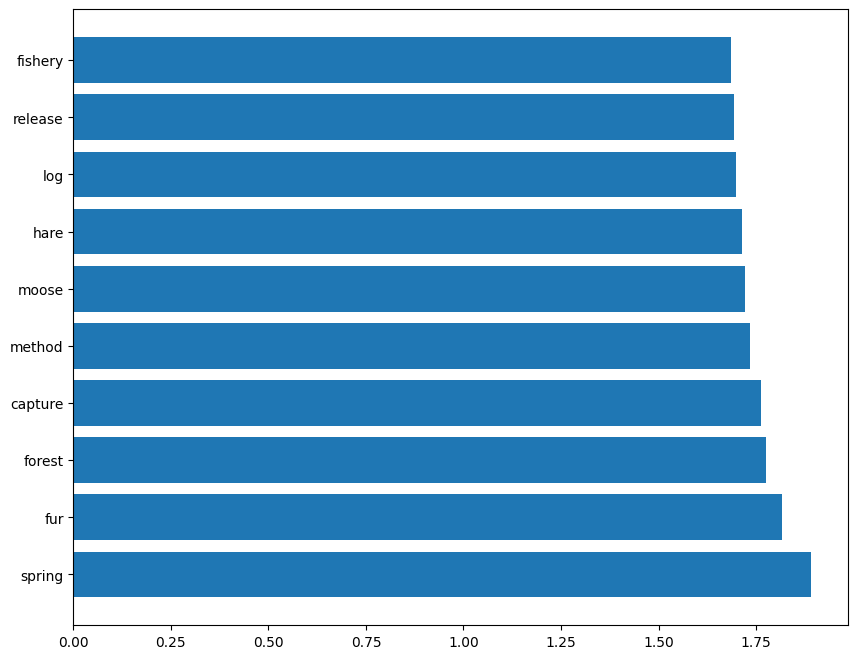

Iteration 9
Exclude: {'shark', 'float', 'kill', 'arrow', 'bush', 'haul', 'spring', 'cast', 'hunting', 'moose', 'release', 'beach', 'line', 'deer', 'use', 'river', 'snow', 'fishing', 'stream', 'ground', 'his', 'forest', 'eel', 'fox', 'fishery', 'capture', 'shoal', 'coast', 'fisherman', 'wound', 'rock', 'pit', 'track', 'seine', 'trout', 'method', 'shore', 'hunt', 'wolf', 'spearing', 'large', 'harpoon', 'pool', 'crab', 'wild', 'bow', 'stone', 'basket', 'deadfall', 'trapper', 'surface', 'rabbit', 'buffalo', 'shell', 'camp', 'canoe', 'sea', 'meat', 'fire', 'net', 'snare', 'dog', 'water', 'shoot', 'coral', 'hand', 'elephant', 'bear', 'fish', 'skin', 'beaver', 'reef', 'crew', 'antelope', 'stick', 'hide', 'bird', 'game', 'woman', 'party', 'deep', 'weir', 'bonito', 'dive', 'coconut', 'tide', 'rod', 'horse', 'pig', 'school', 'rat', 'log', 'mullet', 'trail', 'shallow', 'low', 'band', 'fur', 'animal', 'bait', 'scoop', 'lagoon', 'hook', 'boat', 'hunter', 'salmon', 'hare', 'catch', 'herd', 'drive', 

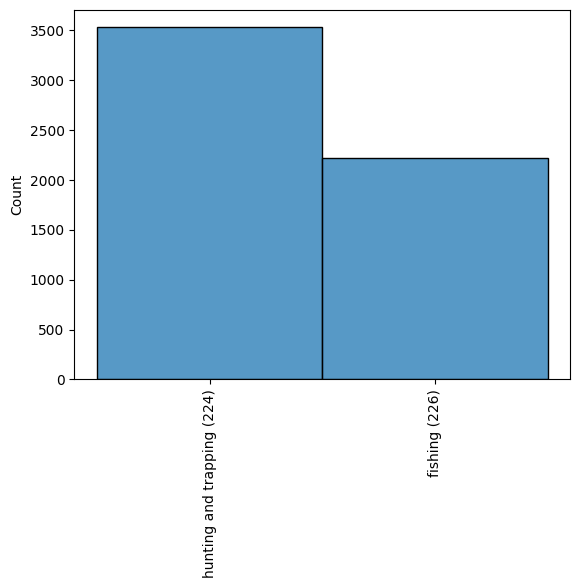

########## None LR 

########## Training LogisticRegression



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.831304347826087
              precision    recall  f1-score   support

         224      0.809     0.951     0.875      1066
         226      0.890     0.637     0.743       659

    accuracy                          0.831      1725
   macro avg      0.850     0.794     0.809      1725
weighted avg      0.840     0.831     0.824      1725



C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:97: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



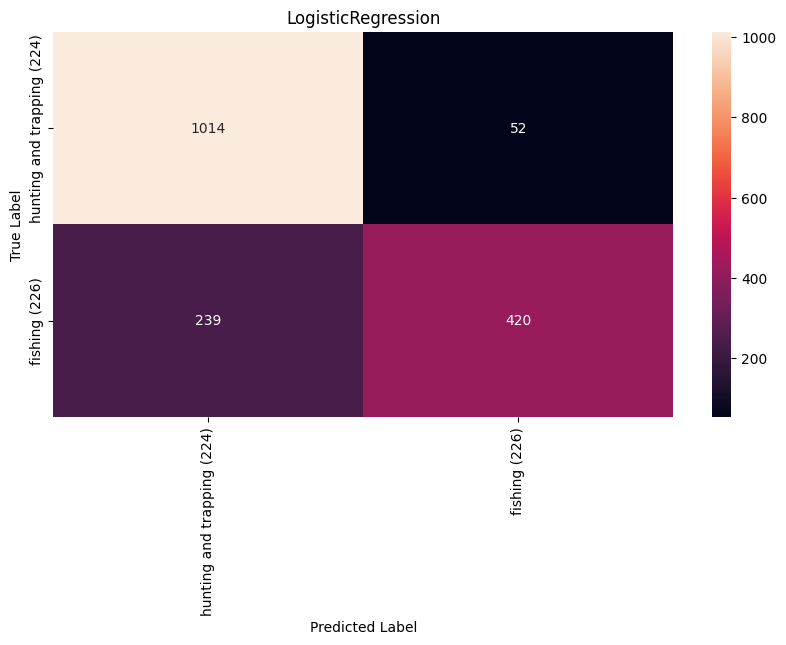

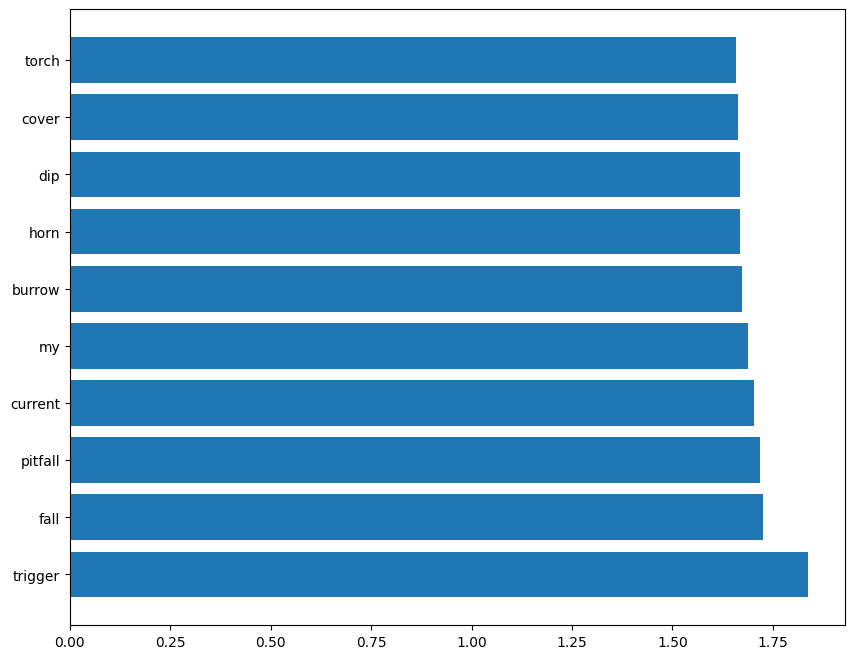

Iteration 10
Exclude: {'shark', 'float', 'kill', 'arrow', 'bush', 'haul', 'spring', 'cast', 'hunting', 'moose', 'release', 'beach', 'line', 'deer', 'use', 'river', 'snow', 'fishing', 'stream', 'ground', 'his', 'forest', 'eel', 'fox', 'fishery', 'capture', 'shoal', 'coast', 'fisherman', 'wound', 'rock', 'pit', 'track', 'seine', 'trout', 'method', 'shore', 'hunt', 'wolf', 'spearing', 'burrow', 'large', 'harpoon', 'pool', 'crab', 'wild', 'bow', 'stone', 'basket', 'deadfall', 'trapper', 'surface', 'pitfall', 'rabbit', 'fall', 'buffalo', 'shell', 'camp', 'my', 'canoe', 'sea', 'meat', 'fire', 'net', 'snare', 'dog', 'water', 'shoot', 'coral', 'hand', 'elephant', 'horn', 'bear', 'fish', 'skin', 'beaver', 'reef', 'trigger', 'crew', 'antelope', 'stick', 'current', 'hide', 'bird', 'game', 'woman', 'party', 'deep', 'torch', 'weir', 'bonito', 'dive', 'coconut', 'tide', 'rod', 'horse', 'pig', 'school', 'rat', 'dip', 'log', 'mullet', 'trail', 'shallow', 'low', 'band', 'fur', 'animal', 'bait', 'cover'

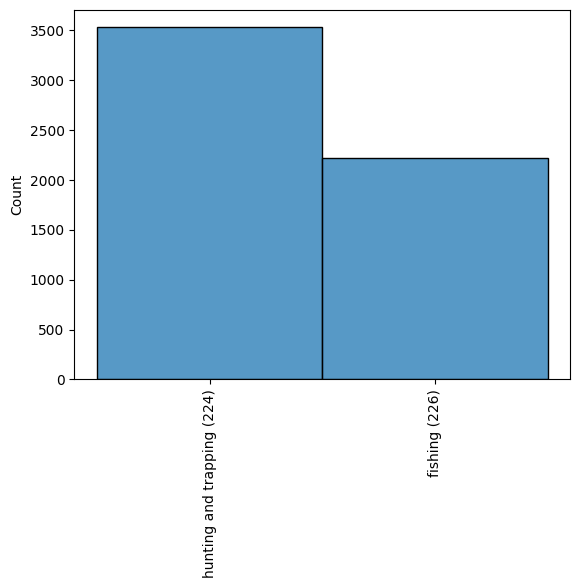

########## None LR 

########## Training LogisticRegression



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.8266666666666667
              precision    recall  f1-score   support

         224      0.804     0.952     0.872      1066
         226      0.890     0.624     0.733       659

    accuracy                          0.827      1725
   macro avg      0.847     0.788     0.802      1725
weighted avg      0.836     0.827     0.819      1725



C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:97: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



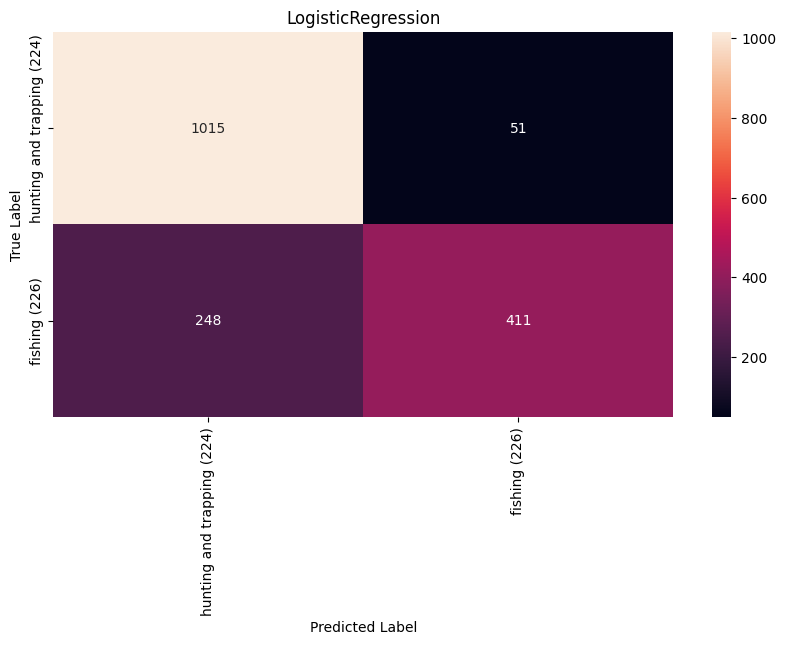

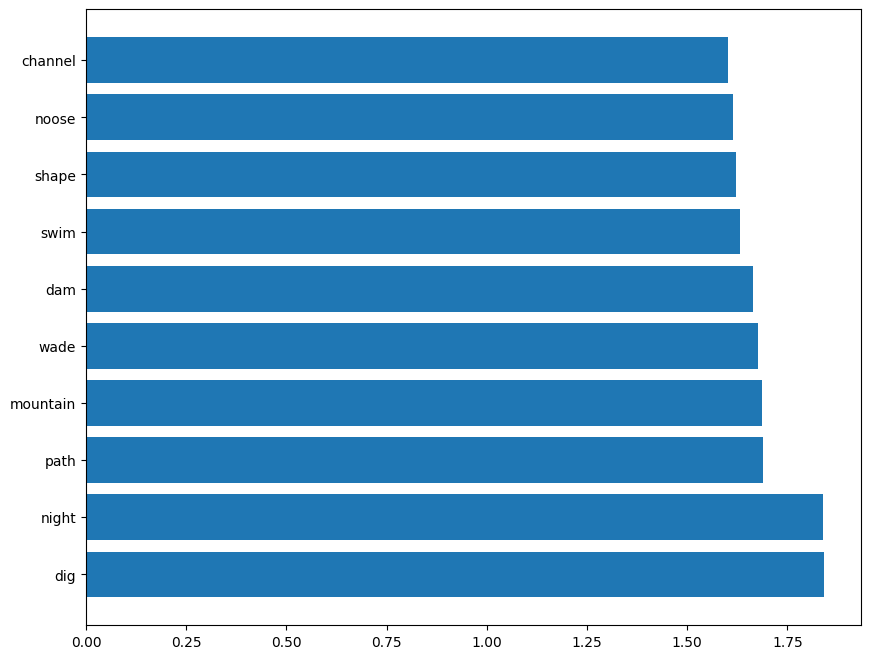

In [42]:
results = iterative_process(models=['LR'],#, 'SVM', 'RF'], 
                            common_indicators=False,
                            chosen_categories=[224, 226],
                            # chosen_categories=[220, 221],
                            iterations=10,
                            top_indicators={'fish', 'kill', 'beaver', 'reef', 'hunting', 'animal', 'deer', 'game', 'river', 'weir', 'fishing', 'canoe', 'sea', 'hook', 'net', 'hunter', 'salmon', 'fisherman', 'water', 'catch', 'hunt', 'line', 'herd', 'boat', 'buffalo', 'stream', 'basket', 'meat', 'snare', 'bear', 'dog'},
                            id='1 (224, 226)',
                            df_performance=df_performance,
                            balanced=False,
                            verbose=True)

In [15]:
df_performance

,precision,recall,f1-score
"1 (224, 226)_LR",0.946649,0.918209,0.929195
"1 (224, 226)_SVM",0.945181,0.926417,0.934249
"1 (224, 226)_RF",0.943834,0.922044,0.930904


In [16]:
print(df_performance.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  precision &    recall &  f1-score \\
\midrule
1 (224, 226)\_LR  &   0.946649 &  0.918209 &  0.929195 \\
1 (224, 226)\_SVM &   0.945181 &  0.926417 &  0.934249 \\
1 (224, 226)\_RF  &   0.943834 &  0.922044 &  0.930904 \\
\bottomrule
\end{tabular}



C:\Users\alhas\AppData\Local\Temp\ipykernel_5224\3683603614.py:1: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



In [17]:
plot_performance(results, fig_path='output/metric/224_226.png')

### 241 and 243

for b in [True, False]:
    print('\n\nBalanced:', b)
    results = iterative_process(common_indicators=False,
                            models=['LR', 'SVM', 'RF'], 
                            chosen_categories=[241, 243], 
                            balanced=b,
                            verbose=True)

In [18]:
# results = iterative_process(common_indicators=False,
#                         models=['LR', 'SVM', 'RF'], 
#                         chosen_categories=[241, 243],
#                         id='1 (241, 243)',
#                         df_performance=df_performance,
#                         balanced=False,
#                         verbose=True)

In [19]:
# plot_performance(results, fig_path='output/metric/241_243.png')

# Cat vs subcategories (binary classification)

results = defaultdict(dict)
for b in [True, False]:
    print('\n\nBalanced:', b)
    
    for i in [224, 226, 241, 243]:
        curr_results = iterative_process(common_indicators=False,
                                    models=['LR', 'SVM', 'RF'], 
                                    specific_cat=i, exact=True, 
                                    balanced=b,
                                    verbose=True)
        results[f'i_{"balanced" if b else "imbalanced"}'] = curr_results

Iteration 1
Exclude: set()

(8717,) (8717,)
8717 documents - 3.86MB (training set)
2 categories


C:\Users\alhas\Documents\development\masters-thesis\utils\main.py:162: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\alhas\Documents\development\masters-thesis\utils\main.py:163: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



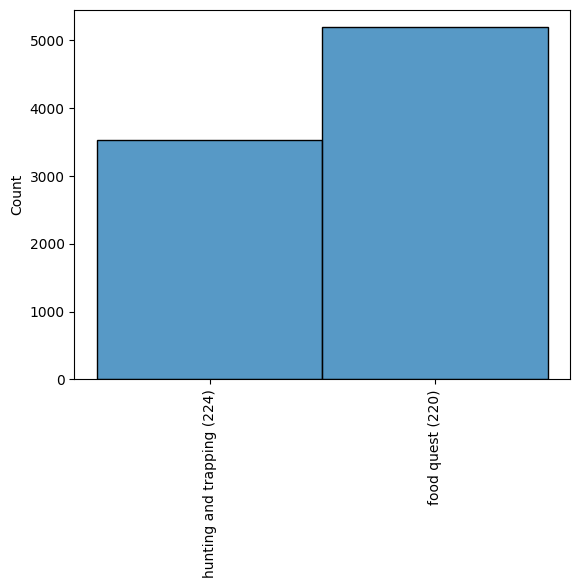

C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## None LR 

########## Training LogisticRegression

########## 0.8883792048929664
              precision    recall  f1-score   support

         220      0.873     0.948     0.909      1535
         224      0.916     0.804     0.856      1081

    accuracy                          0.888      2616
   macro avg      0.894     0.876     0.882      2616
weighted avg      0.891     0.888     0.887      2616



C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:97: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



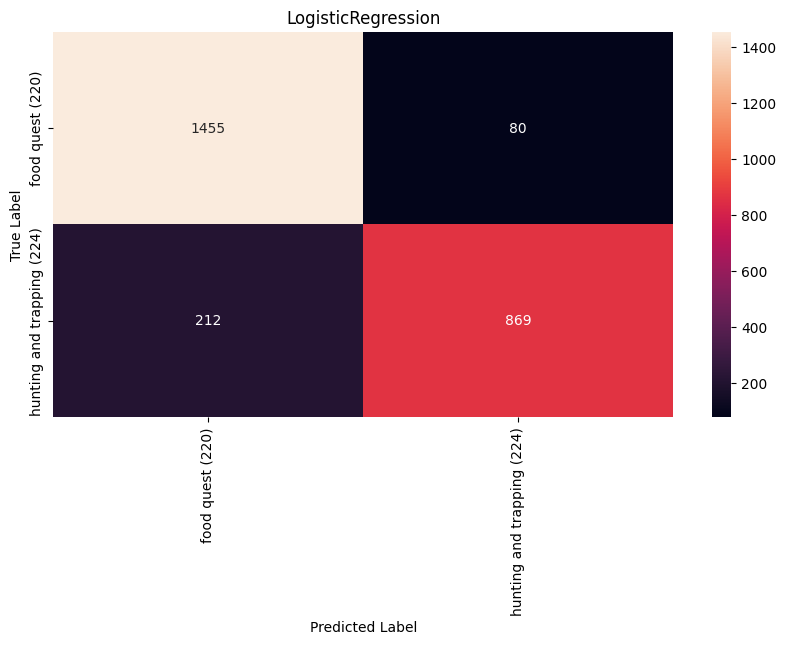

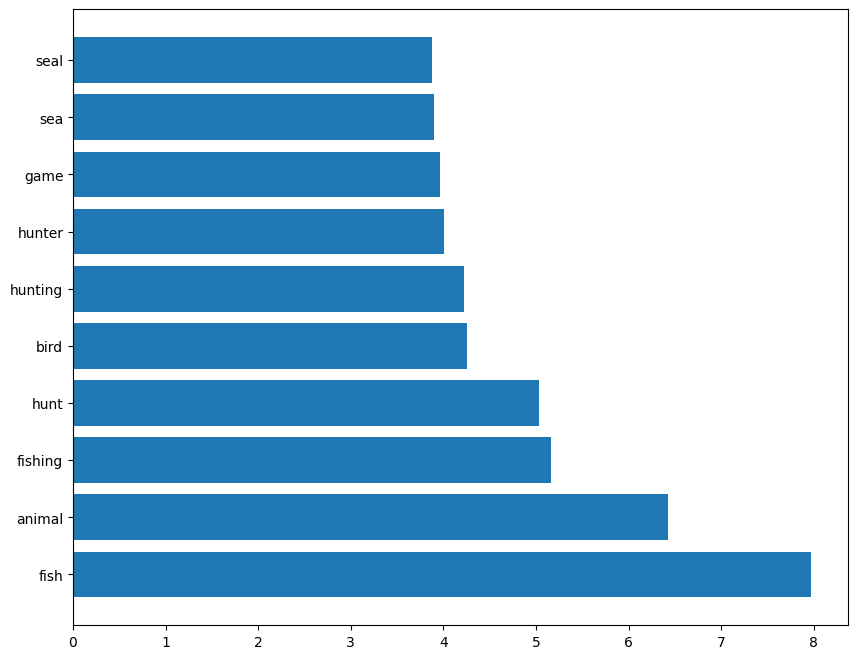

########## None SVM 

########## Training LinearSVC



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.8899082568807339
              precision    recall  f1-score   support

         220      0.878     0.943     0.910      1535
         224      0.910     0.814     0.859      1081

    accuracy                          0.890      2616
   macro avg      0.894     0.879     0.884      2616
weighted avg      0.891     0.890     0.889      2616



C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:97: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



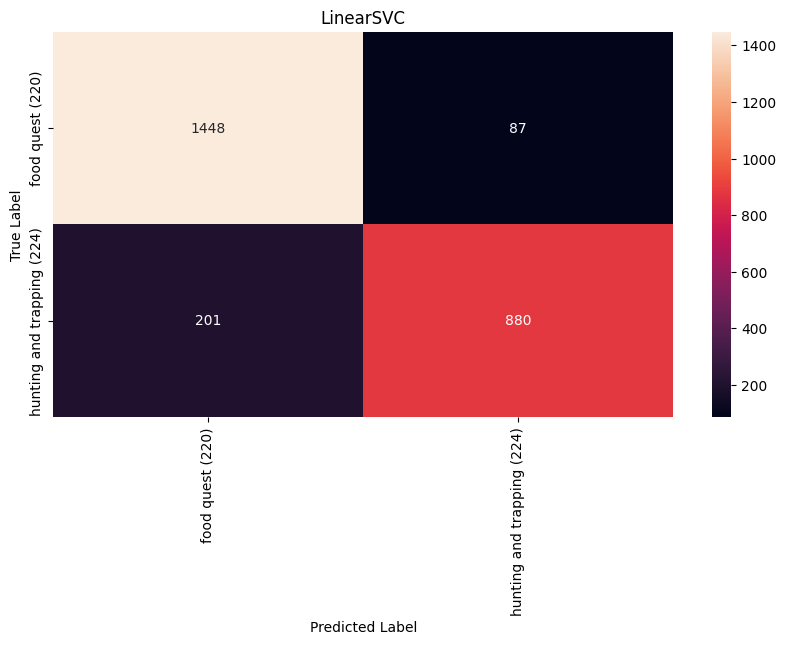

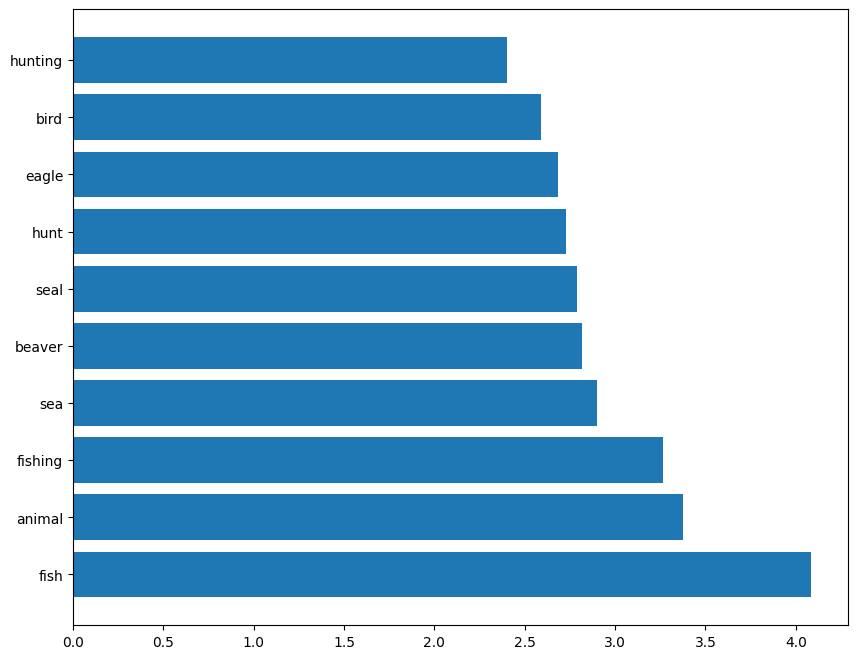

########## None RF 

########## Training RandomForestClassifier



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.8757645259938838
              precision    recall  f1-score   support

         220      0.872     0.924     0.897      1535
         224      0.883     0.807     0.843      1081

    accuracy                          0.876      2616
   macro avg      0.877     0.866     0.870      2616
weighted avg      0.876     0.876     0.875      2616



C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:97: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


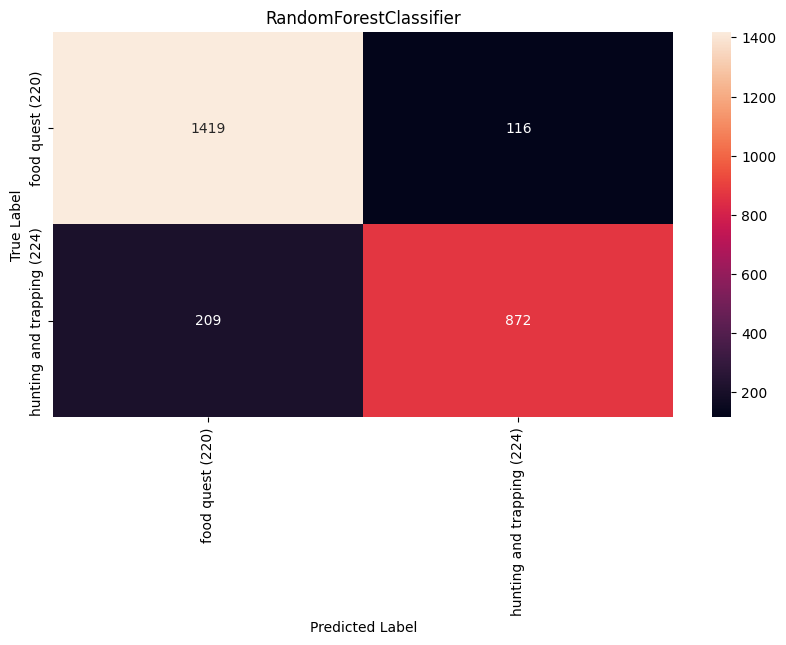

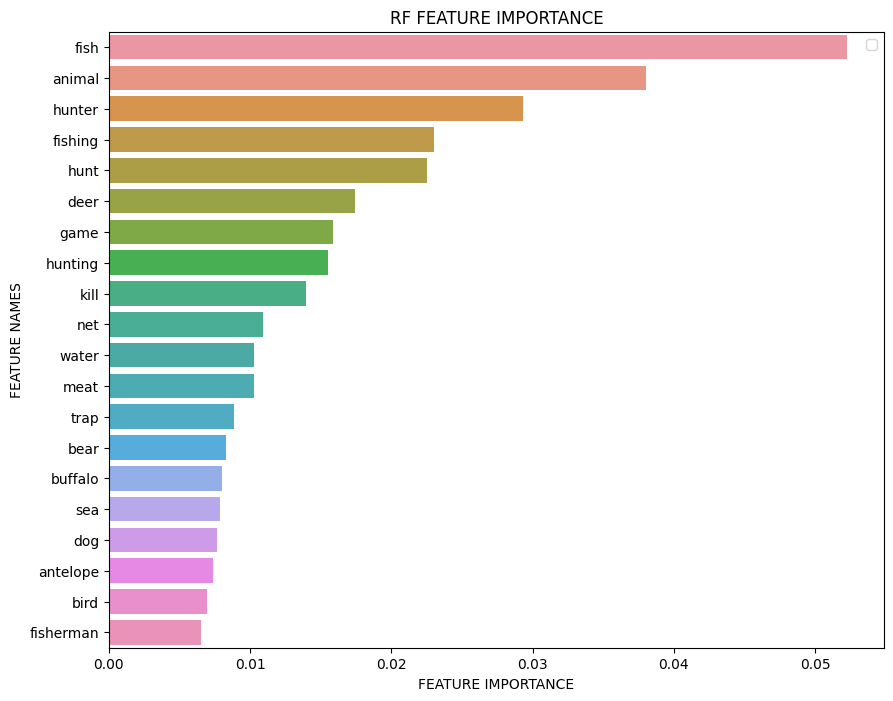

Iteration 1
Exclude: set()

(8717,) (8717,)
8717 documents - 3.86MB (training set)
2 categories


C:\Users\alhas\Documents\development\masters-thesis\utils\main.py:162: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\alhas\Documents\development\masters-thesis\utils\main.py:163: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



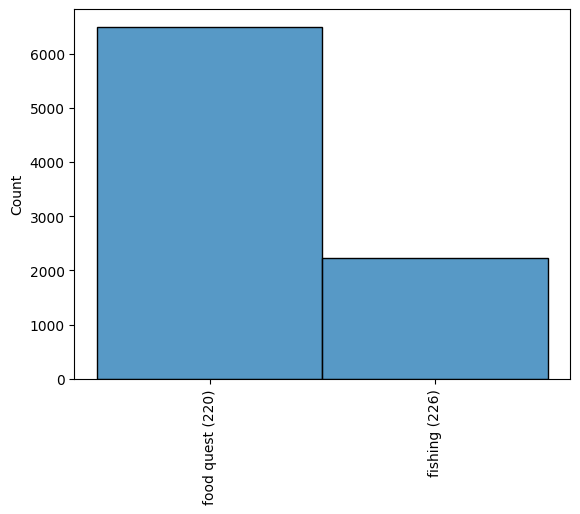

C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## None LR 

########## Training LogisticRegression

########## 0.8784403669724771
              precision    recall  f1-score   support

         220      0.891     0.955     0.922      1966
         226      0.827     0.646     0.725       650

    accuracy                          0.878      2616
   macro avg      0.859     0.801     0.824      2616
weighted avg      0.875     0.878     0.873      2616



C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:97: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



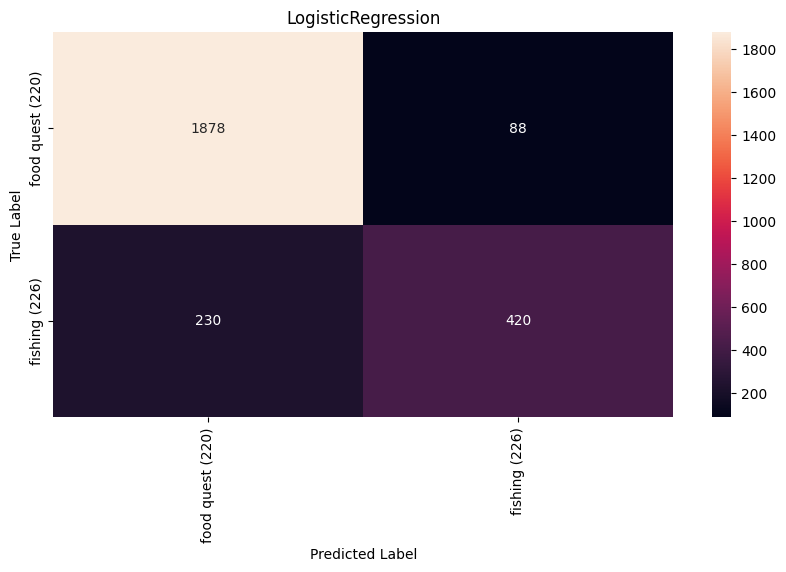

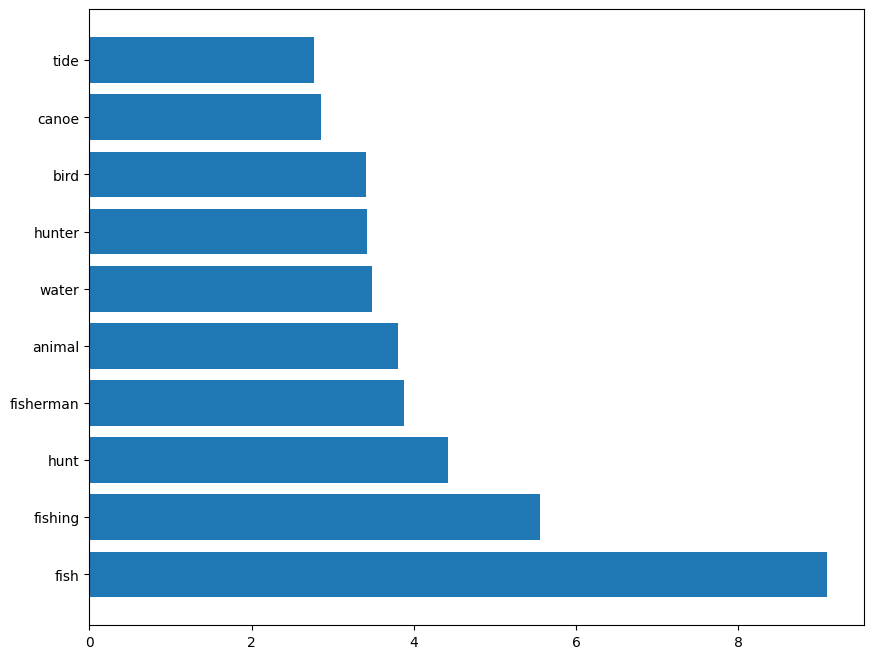

########## None SVM 

########## Training LinearSVC



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.8879969418960245
              precision    recall  f1-score   support

         220      0.908     0.947     0.927      1966
         226      0.816     0.709     0.759       650

    accuracy                          0.888      2616
   macro avg      0.862     0.828     0.843      2616
weighted avg      0.885     0.888     0.885      2616



C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:97: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



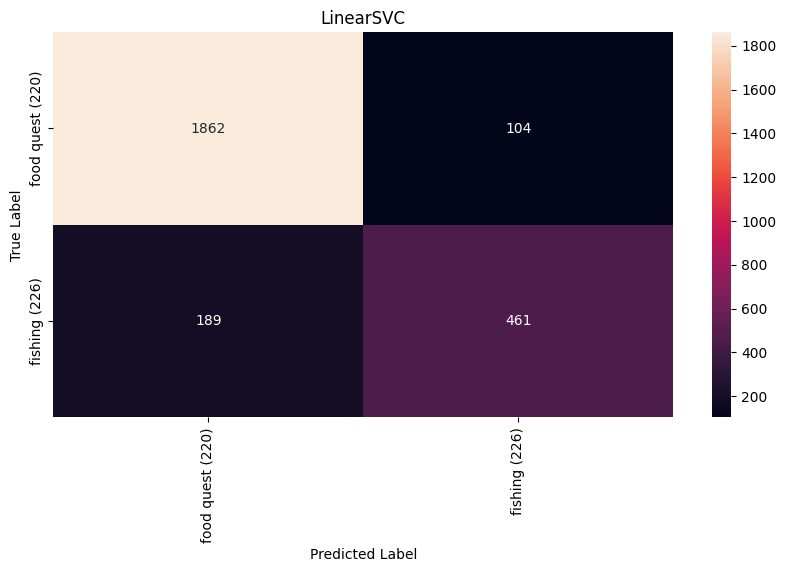

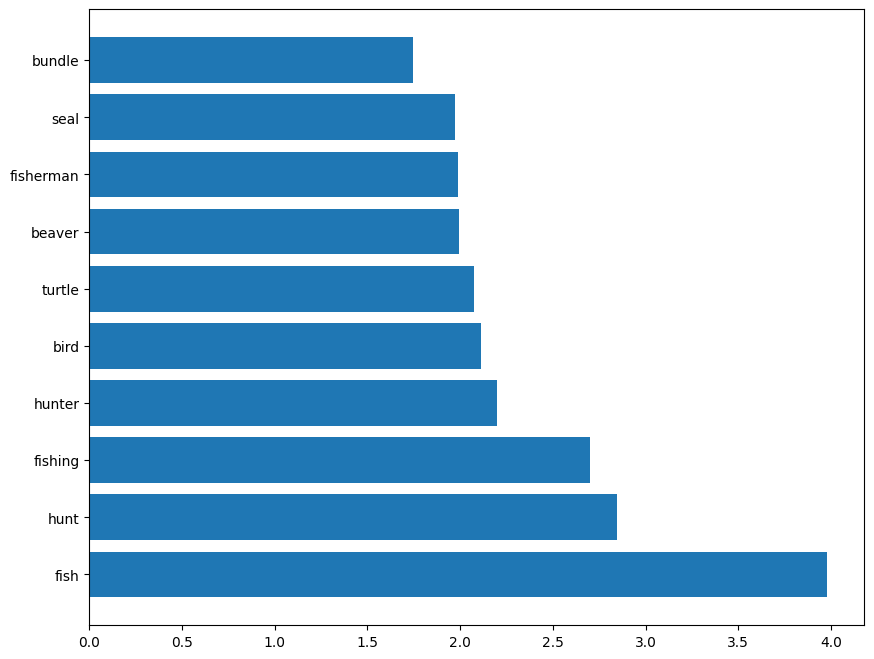

########## None RF 

########## Training RandomForestClassifier



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.8818807339449541
              precision    recall  f1-score   support

         220      0.911     0.934     0.922      1966
         226      0.784     0.725     0.753       650

    accuracy                          0.882      2616
   macro avg      0.847     0.829     0.838      2616
weighted avg      0.879     0.882     0.880      2616



C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:97: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


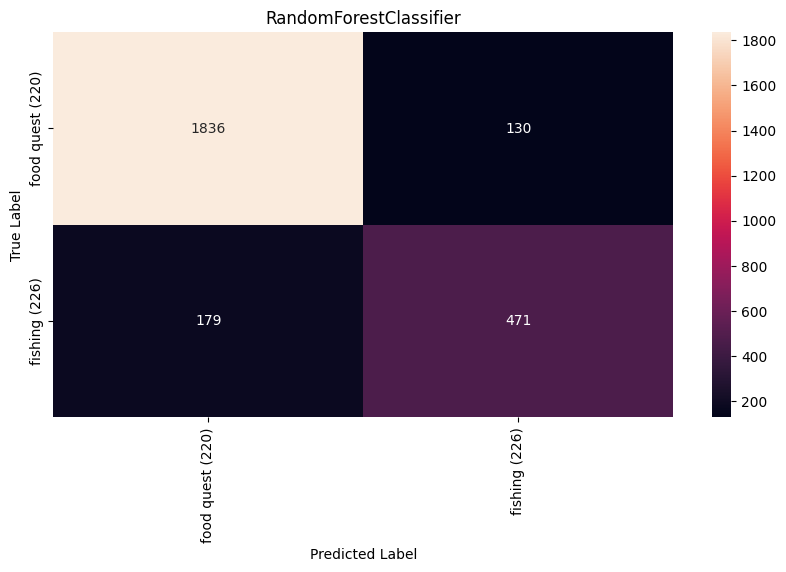

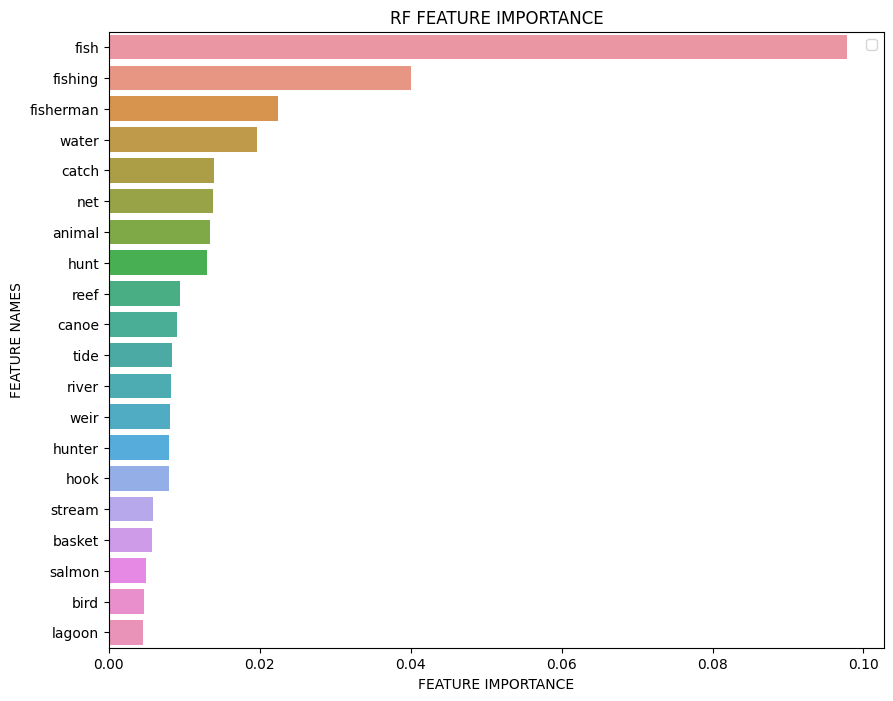

In [20]:
results = defaultdict(dict)
for i in [224, 226]:#, 241, 243]:
    curr_results = iterative_process(common_indicators=False,
                                models=['LR', 'SVM', 'RF'], 
                                specific_cat=i, exact=True, 
                                id=f'2 ({i})',
                                df_performance=df_performance,
                                balanced=False,
                                verbose=True)
    results[i] = curr_results

In [22]:
for i in [224, 226]:#, 241, 243]:
    plot_performance(results[i], fig_path='output/metric/224_220.png')

# Cat vs subcategories (multi-class classification)



Balanced: True
Iteration 1
Exclude: set()

(25545,) (25545,)
25545 documents - 13.73MB (training set)
9 categories


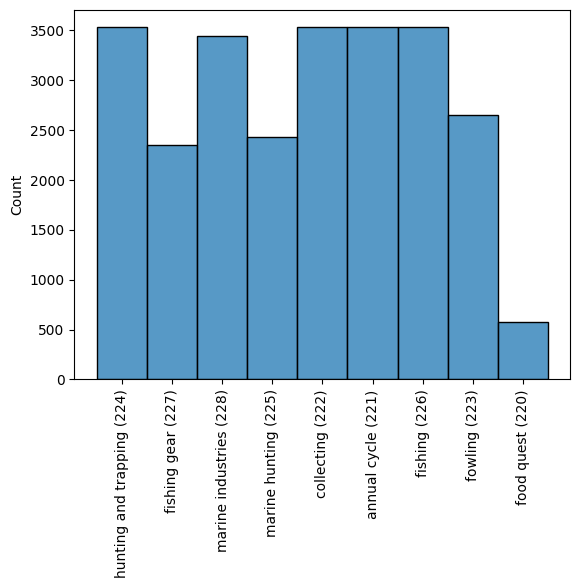

########## None LR 

########## Training LogisticRegression



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.7034185803757829
              precision    recall  f1-score   support

         220      0.909     0.108     0.193       185
         221      0.740     0.710     0.724      1096
         222      0.465     0.873     0.607      1016
         223      0.891     0.652     0.753       799
         224      0.802     0.809     0.806      1050
         225      0.866     0.728     0.791       684
         226      0.708     0.594     0.646      1084
         227      0.695     0.487     0.573       716
         228      0.802     0.817     0.809      1034

    accuracy                          0.703      7664
   macro avg      0.764     0.642     0.656      7664
weighted avg      0.743     0.703     0.702      7664



C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:97: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



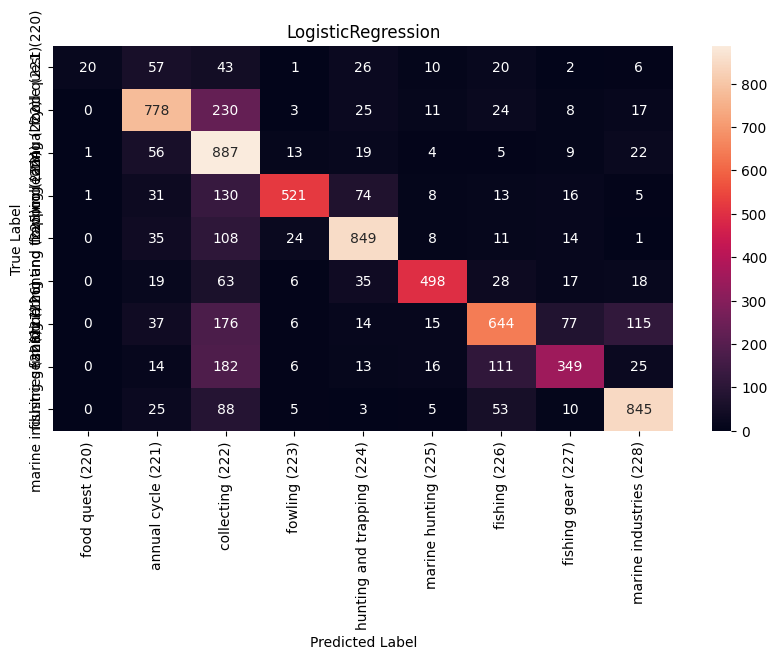

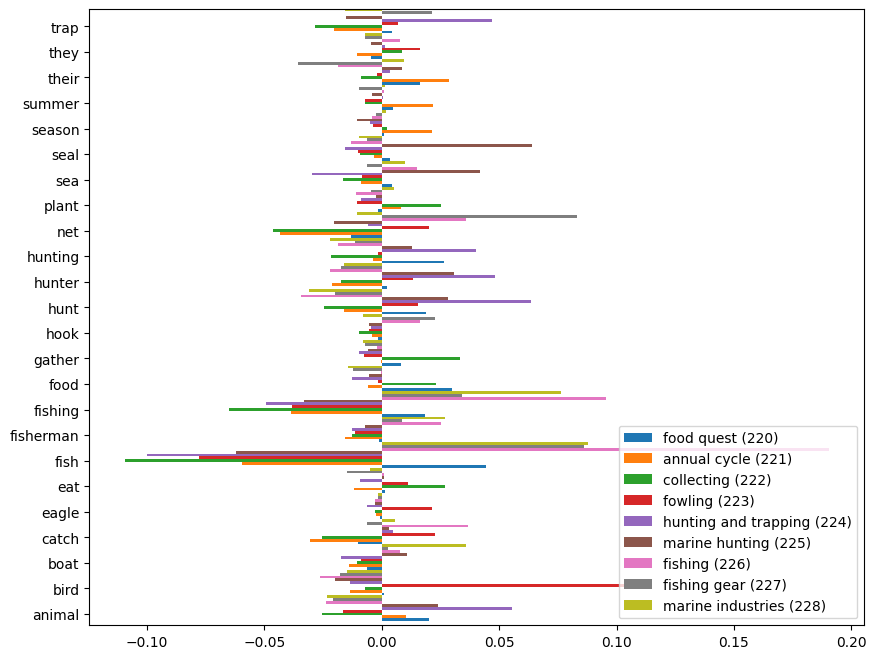

########## None SVM 

########## Training LinearSVC



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.7013308977035491
              precision    recall  f1-score   support

         220      0.636     0.227     0.335       185
         221      0.765     0.669     0.714      1096
         222      0.474     0.867     0.613      1016
         223      0.850     0.661     0.744       799
         224      0.808     0.788     0.798      1050
         225      0.825     0.756     0.789       684
         226      0.682     0.601     0.639      1084
         227      0.675     0.496     0.572       716
         228      0.818     0.812     0.815      1034

    accuracy                          0.701      7664
   macro avg      0.726     0.653     0.669      7664
weighted avg      0.730     0.701     0.702      7664



C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:97: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



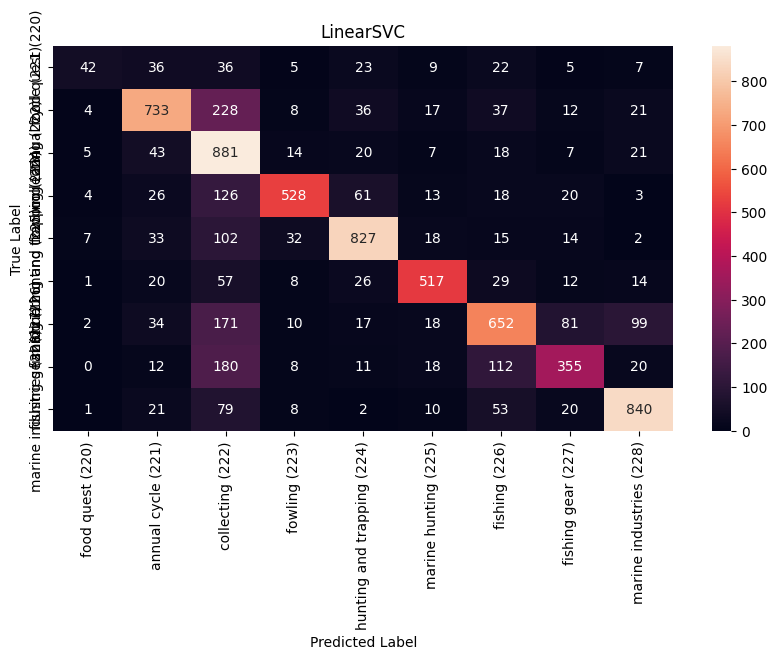

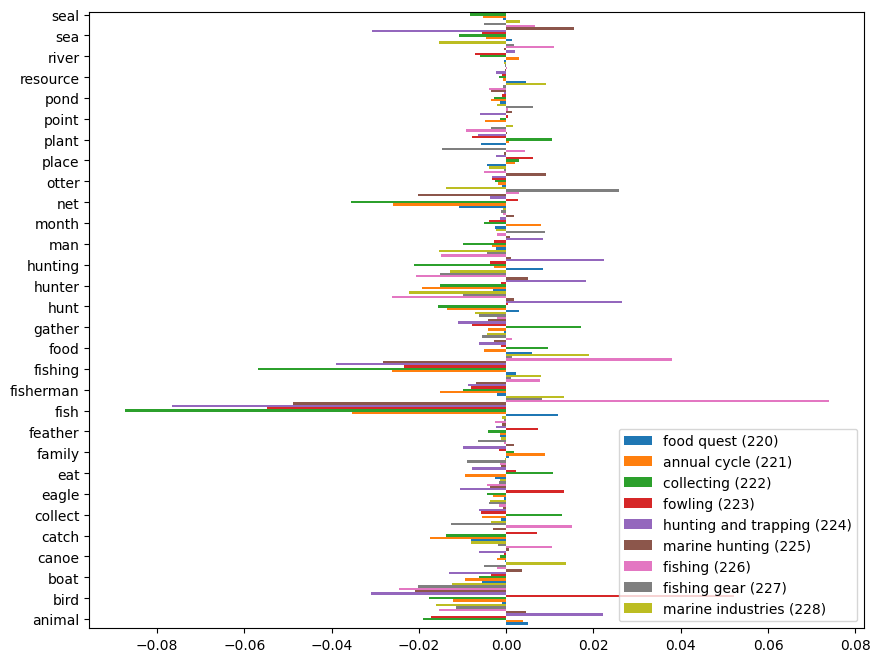

########## None RF 

########## Training RandomForestClassifier



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.6614039665970772
              precision    recall  f1-score   support

         220      1.000     0.038     0.073       185
         221      0.714     0.656     0.684      1096
         222      0.450     0.846     0.587      1016
         223      0.865     0.618     0.721       799
         224      0.727     0.798     0.761      1050
         225      0.797     0.690     0.740       684
         226      0.629     0.576     0.601      1084
         227      0.688     0.398     0.504       716
         228      0.758     0.745     0.751      1034

    accuracy                          0.661      7664
   macro avg      0.736     0.596     0.603      7664
weighted avg      0.702     0.661     0.656      7664



C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:97: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


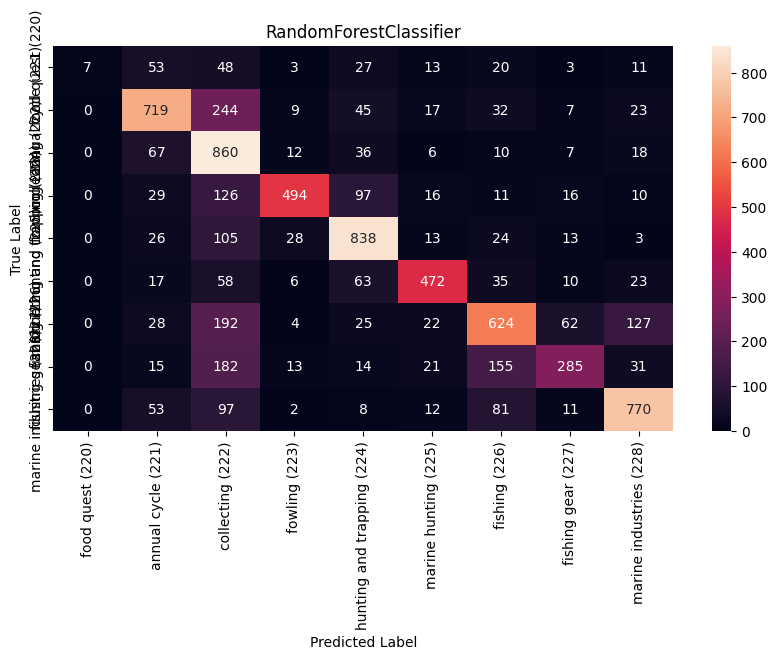

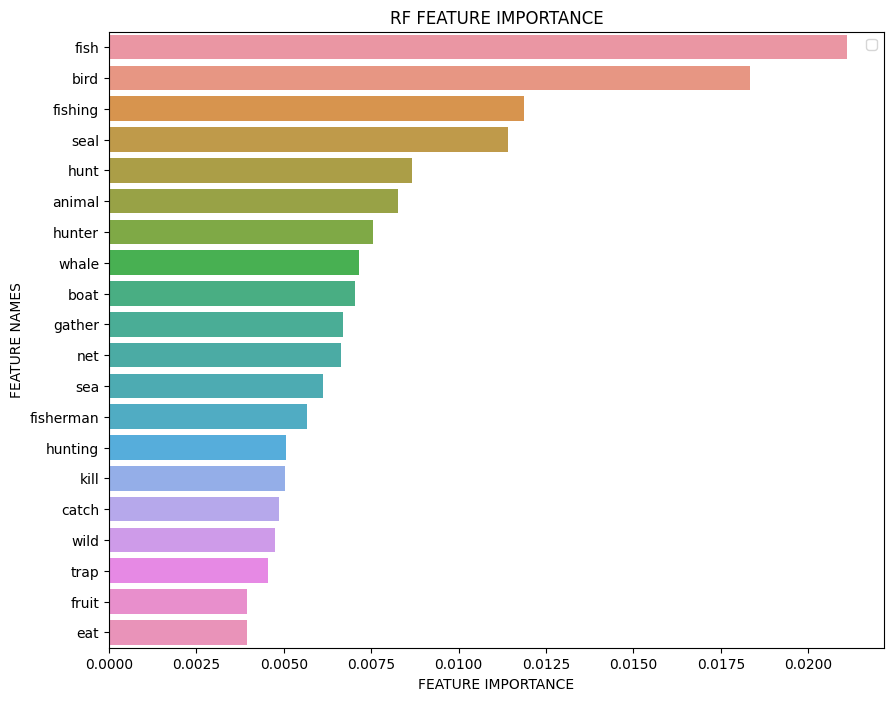



Balanced: False
Iteration 1
Exclude: set()

(8717,) (8717,)
8717 documents - 3.86MB (training set)
9 categories


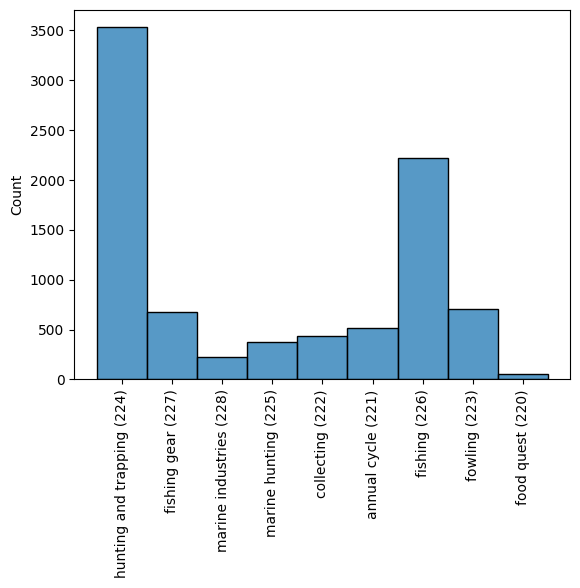

########## None LR 

########## Training LogisticRegression



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.7584097859327217
              precision    recall  f1-score   support

         220      0.000     0.000     0.000        18
         221      0.817     0.531     0.644       143
         222      0.870     0.545     0.670       123
         223      0.922     0.562     0.698       210
         224      0.737     0.968     0.836      1081
         225      0.934     0.483     0.637       118
         226      0.742     0.834     0.786       650
         227      0.729     0.340     0.464       206
         228      0.727     0.119     0.205        67

    accuracy                          0.758      2616
   macro avg      0.720     0.487     0.549      2616
weighted avg      0.767     0.758     0.734      2616



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels w

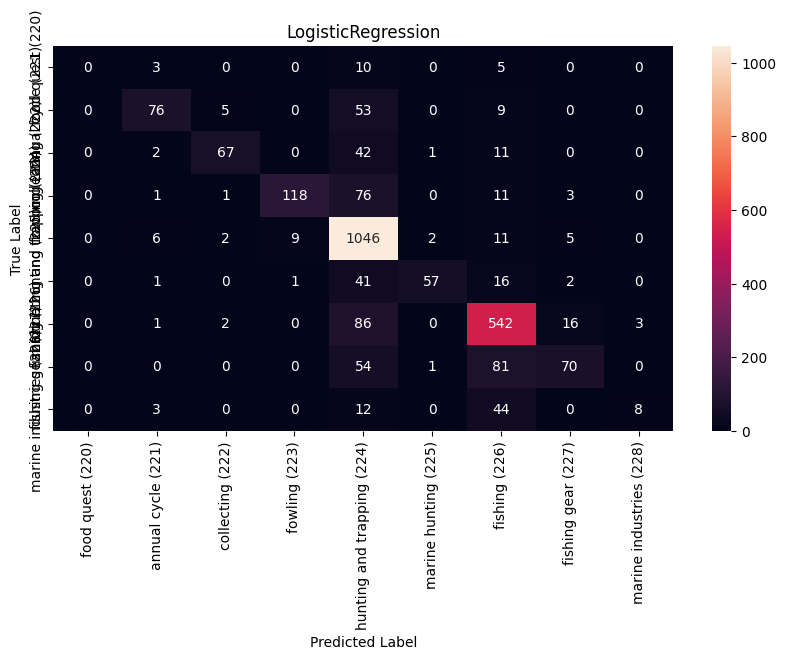

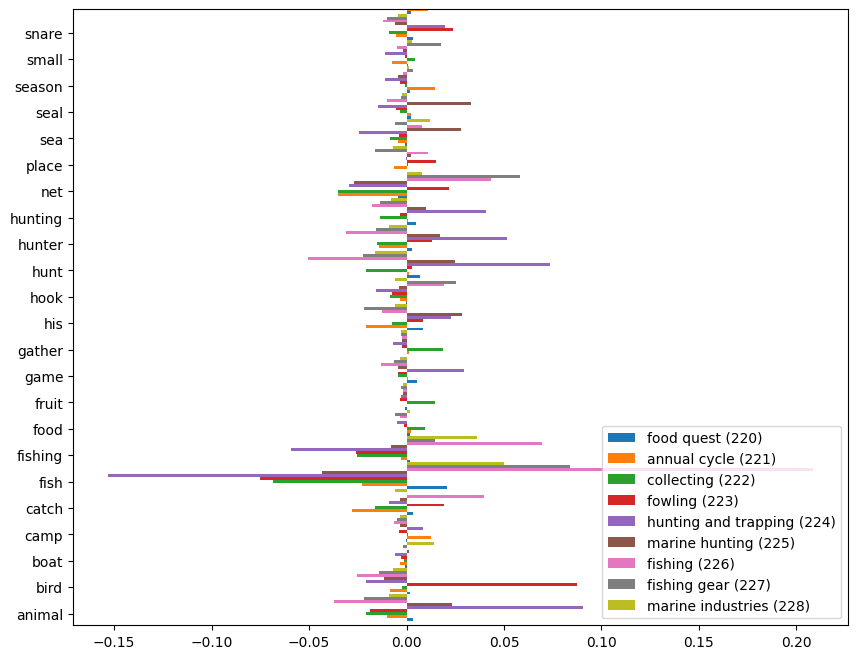

########## None SVM 

########## Training LinearSVC



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.7737003058103975
              precision    recall  f1-score   support

         220      0.000     0.000     0.000        18
         221      0.689     0.573     0.626       143
         222      0.781     0.724     0.751       123
         223      0.863     0.657     0.746       210
         224      0.785     0.938     0.855      1081
         225      0.849     0.669     0.749       118
         226      0.776     0.795     0.786       650
         227      0.576     0.369     0.450       206
         228      0.707     0.433     0.537        67

    accuracy                          0.774      2616
   macro avg      0.670     0.573     0.611      2616
weighted avg      0.763     0.774     0.761      2616



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels w

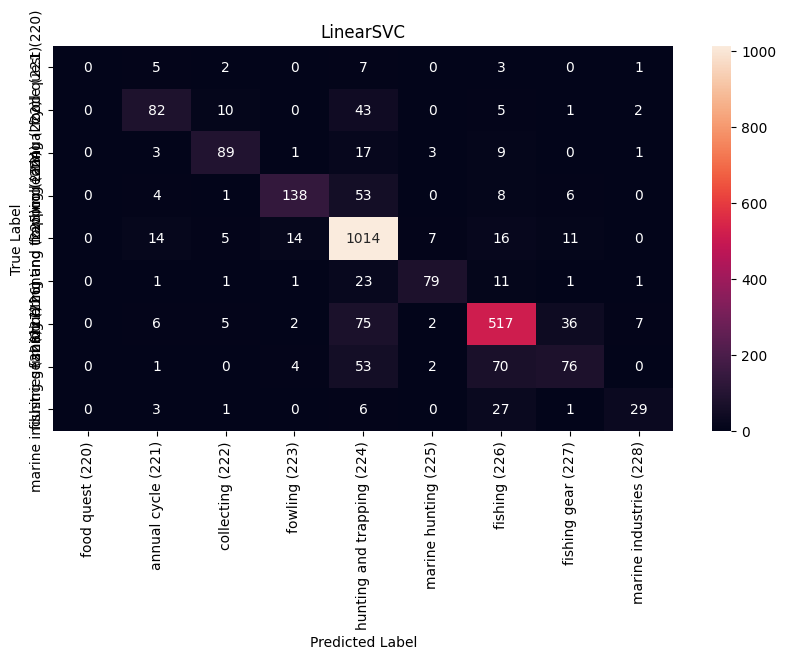

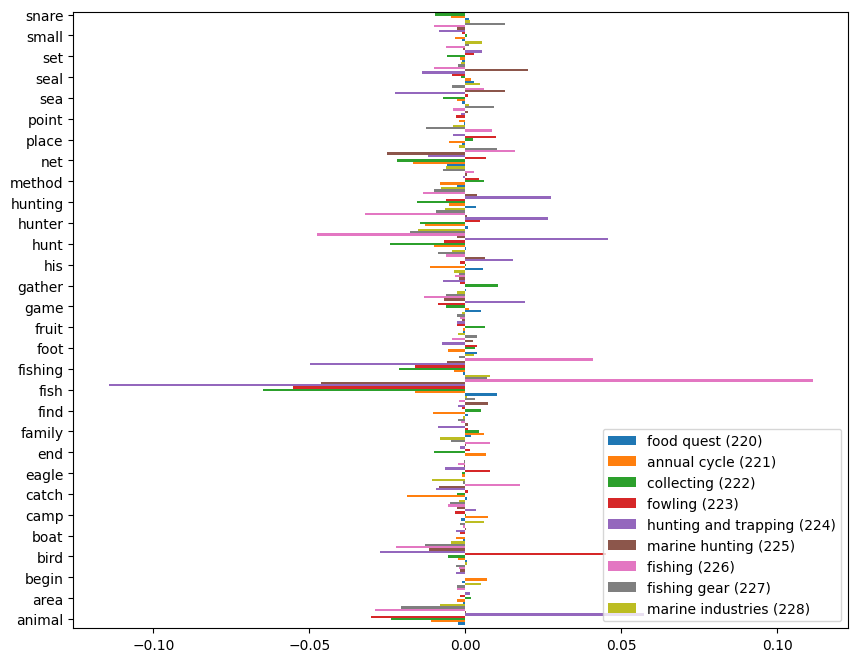

########## None RF 

########## Training RandomForestClassifier



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.72782874617737
              precision    recall  f1-score   support

         220      0.000     0.000     0.000        18
         221      0.719     0.322     0.444       143
         222      0.857     0.634     0.729       123
         223      0.873     0.457     0.600       210
         224      0.725     0.956     0.824      1081
         225      0.897     0.441     0.591       118
         226      0.687     0.843     0.757       650
         227      0.710     0.214     0.328       206
         228      0.875     0.104     0.187        67

    accuracy                          0.728      2616
   macro avg      0.705     0.441     0.496      2616
weighted avg      0.739     0.728     0.693      2616



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels w

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


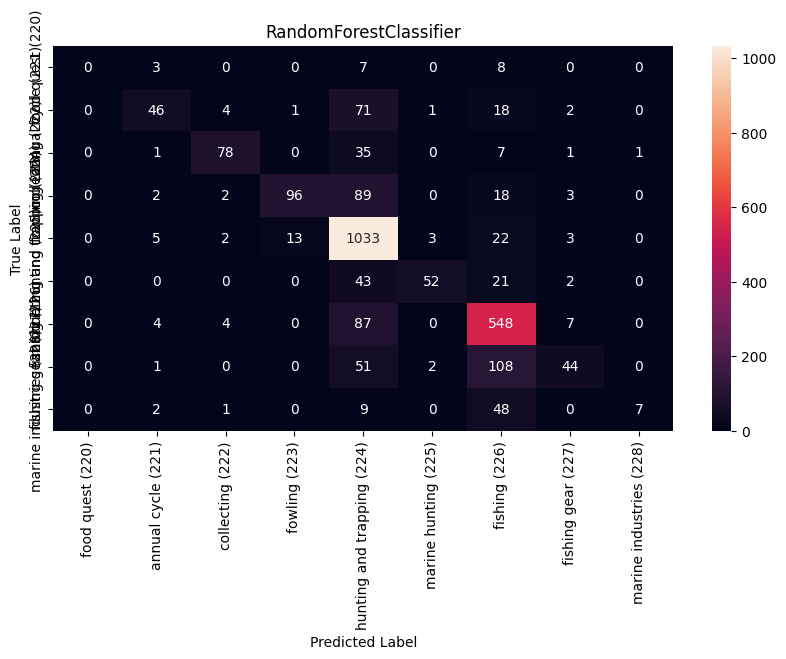

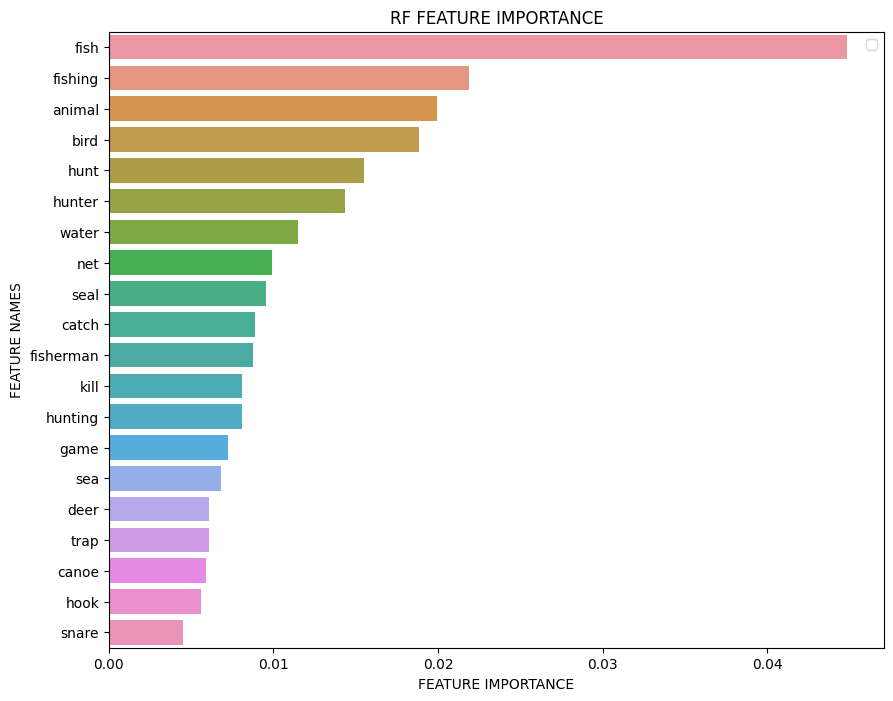

In [23]:
results = defaultdict(dict)
for b in [True, False]:
    print('\n\nBalanced:', b)
    for i in [220]:#, 240]:
        curr_results = iterative_process(common_indicators=False,
                                    models=['LR', 'SVM', 'RF'], 
                                    specific_cat=i, exact=False, 
                                    id=f'3 ({i})',
                                    df_performance=df_performance,
                                    balanced=b,
                                    verbose=True)
        results[f'{i}_{"balanced" if b else "imbalanced"}'] = curr_results
        

In [26]:

for b in [True, False]:
    print('\n\nBalanced:', b)
    for i in [220]:#, 240]:for i in [220]:#, 240]:
        plot_performance(results[f'{i}_{"balanced" if b else "imbalanced"}'], fig_path='output/metric/220_240.png')



Balanced: True




Balanced: False


In [31]:
df_performance = df_performance.round(2)


In [32]:
print(df_performance.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  precision &  recall &  f1-score \\
\midrule
1 (224, 226)\_LR  &       0.95 &    0.92 &      0.93 \\
1 (224, 226)\_SVM &       0.95 &    0.93 &      0.93 \\
1 (224, 226)\_RF  &       0.94 &    0.92 &      0.93 \\
2 (224)\_LR       &       0.89 &    0.88 &      0.88 \\
2 (224)\_SVM      &       0.89 &    0.88 &      0.88 \\
2 (224)\_RF       &       0.88 &    0.87 &      0.87 \\
2 (226)\_LR       &       0.86 &    0.80 &      0.82 \\
2 (226)\_SVM      &       0.86 &    0.83 &      0.84 \\
2 (226)\_RF       &       0.85 &    0.83 &      0.84 \\
3 (220)\_LR       &       0.72 &    0.49 &      0.55 \\
3 (220)\_SVM      &       0.67 &    0.57 &      0.61 \\
3 (220)\_RF       &       0.70 &    0.44 &      0.50 \\
\bottomrule
\end{tabular}



C:\Users\alhas\AppData\Local\Temp\ipykernel_5224\3683603614.py:1: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



Iteration 1
Exclude: set()

(16758,) (16758,)
16758 documents - 8.66MB (training set)
5 categories


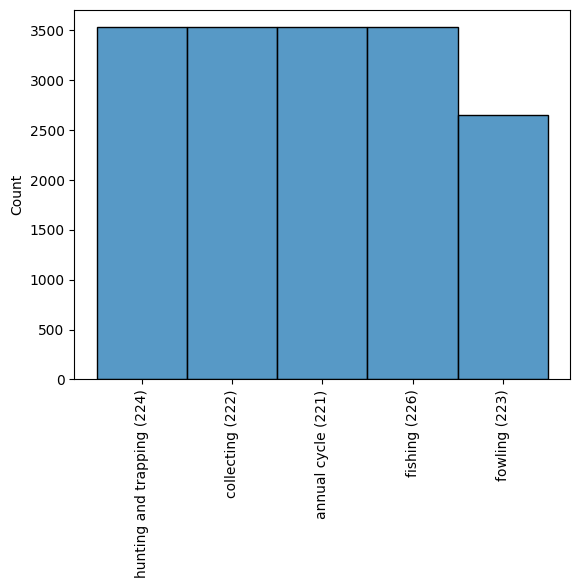

########## None LR 

########## Training LogisticRegression



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.7826173428798727
              precision    recall  f1-score   support

         221      0.801     0.734     0.766      1090
         222      0.593     0.879     0.708      1050
         223      0.922     0.681     0.783       793
         224      0.852     0.823     0.837      1035
         226      0.926     0.774     0.843      1060

    accuracy                          0.783      5028
   macro avg      0.819     0.778     0.787      5028
weighted avg      0.813     0.783     0.787      5028



C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:97: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



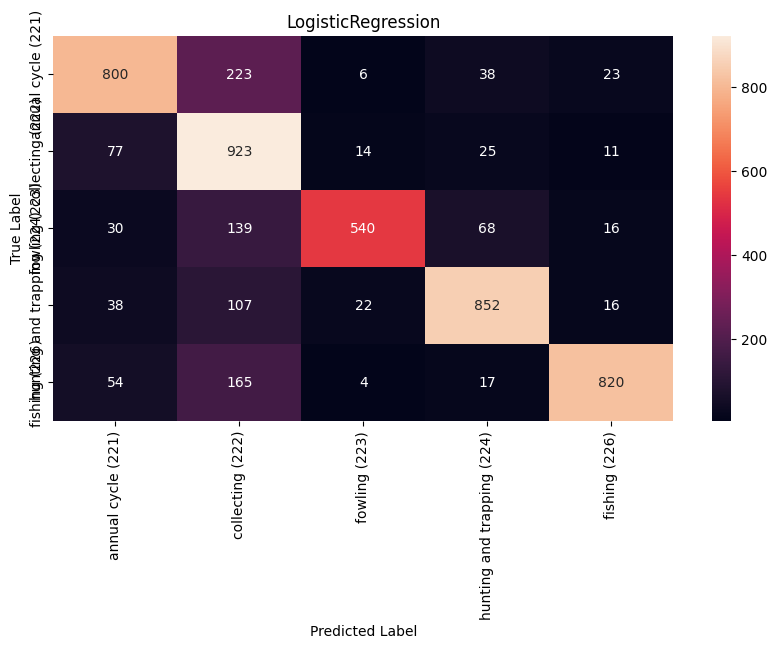

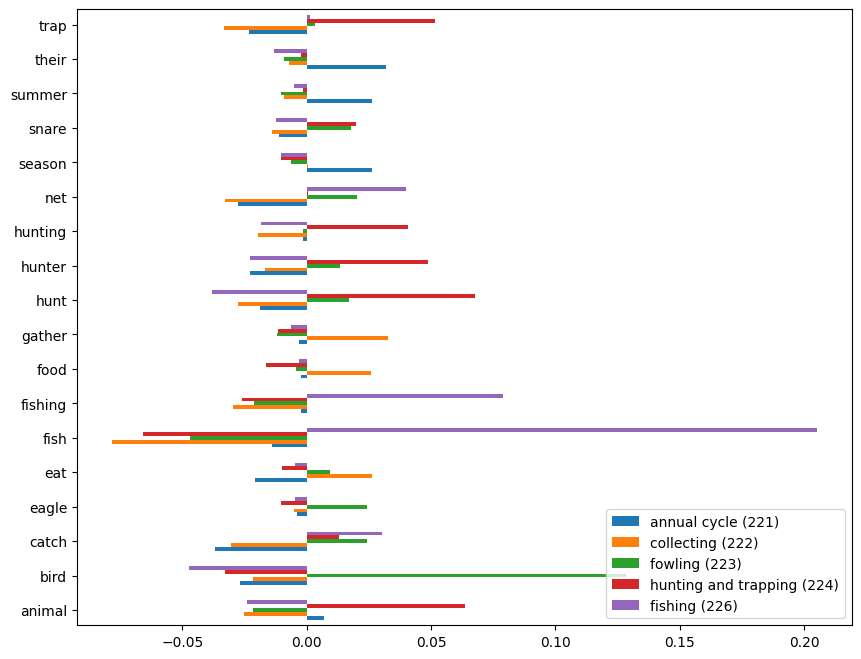

########## None SVM 

########## Training LinearSVC



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.7742641209228321
              precision    recall  f1-score   support

         221      0.815     0.710     0.759      1090
         222      0.591     0.867     0.703      1050
         223      0.858     0.696     0.769       793
         224      0.845     0.814     0.829      1035
         226      0.906     0.769     0.832      1060

    accuracy                          0.774      5028
   macro avg      0.803     0.771     0.778      5028
weighted avg      0.800     0.774     0.779      5028



C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:97: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



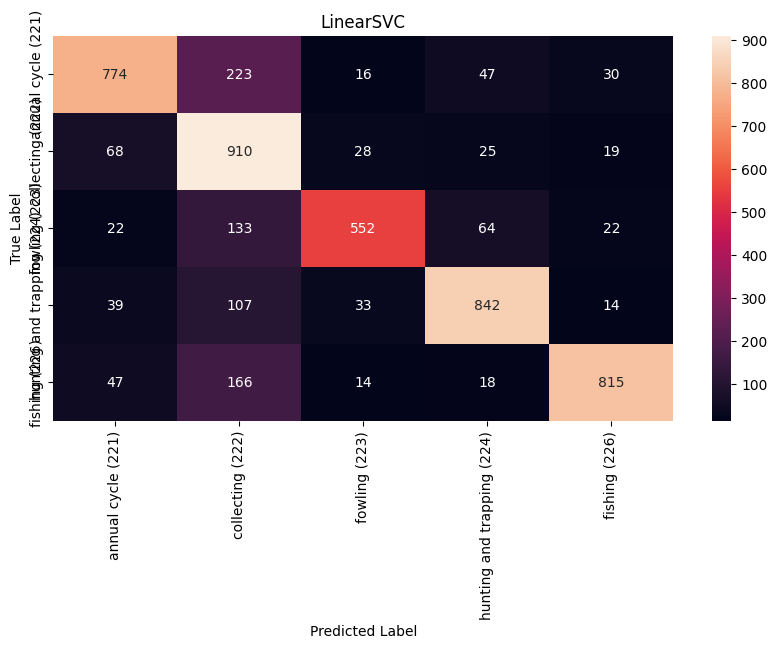

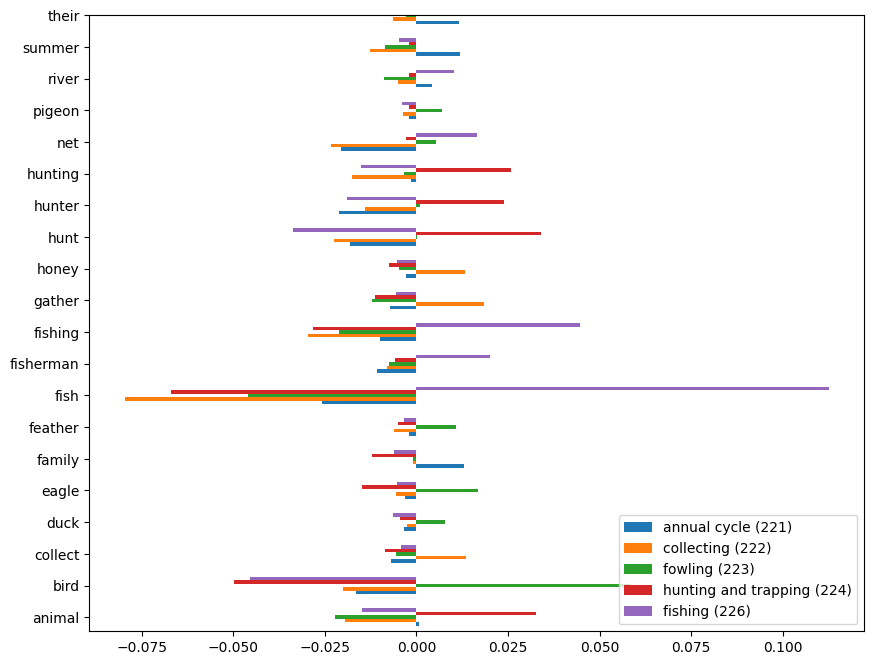

########## None RF 

########## Training RandomForestClassifier



C:\Users\alhas\anaconda3\envs\thesis\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



########## 0.7583532219570406
              precision    recall  f1-score   support

         221      0.808     0.698     0.749      1090
         222      0.582     0.854     0.692      1050
         223      0.928     0.617     0.741       793
         224      0.785     0.823     0.803      1035
         226      0.873     0.768     0.817      1060

    accuracy                          0.758      5028
   macro avg      0.795     0.752     0.761      5028
weighted avg      0.789     0.758     0.761      5028



C:\Users\alhas\Documents\development\masters-thesis\utils\plots.py:97: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


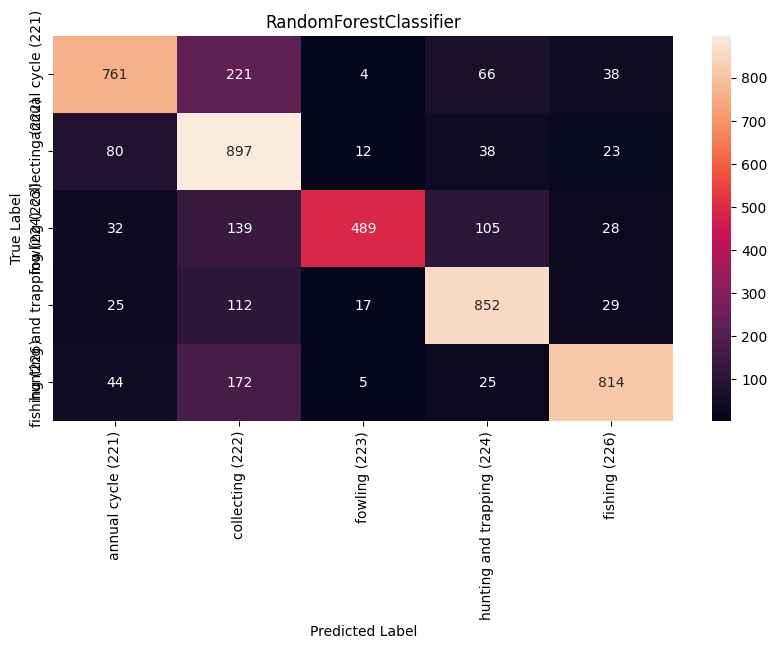

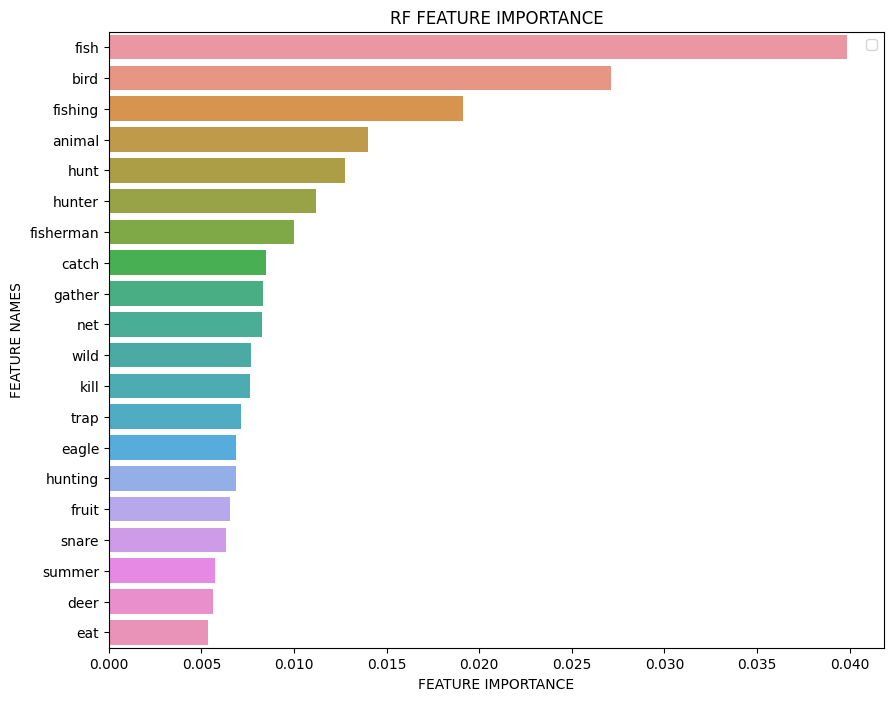

In [34]:
results = iterative_process(models=['LR', 'SVM', 'RF'], 
                            common_indicators=False,
                            chosen_categories=[221, 222, 223, 224, 226],
                            # chosen_categories=[220, 221],
                            # iterations=1,
                            id='1 (221..226)',
                            df_performance=df_performance,
                            # balanced=False,
                            verbose=True)

In [36]:
print(df_performance.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  precision &    recall &  f1-score \\
\midrule
1 (224, 226)\_LR  &   0.946649 &  0.918209 &  0.929195 \\
1 (224, 226)\_SVM &   0.945181 &  0.926417 &  0.934249 \\
1 (224, 226)\_RF  &   0.946851 &  0.924210 &  0.933370 \\
2 (224)\_LR       &   0.890000 &  0.880000 &  0.880000 \\
2 (224)\_SVM      &   0.890000 &  0.880000 &  0.880000 \\
2 (224)\_RF       &   0.880000 &  0.870000 &  0.870000 \\
2 (226)\_LR       &   0.860000 &  0.800000 &  0.820000 \\
2 (226)\_SVM      &   0.860000 &  0.830000 &  0.840000 \\
2 (226)\_RF       &   0.850000 &  0.830000 &  0.840000 \\
3 (220)\_LR       &   0.720000 &  0.490000 &  0.550000 \\
3 (220)\_SVM      &   0.670000 &  0.570000 &  0.610000 \\
3 (220)\_RF       &   0.700000 &  0.440000 &  0.500000 \\
1 (221..226)\_LR  &   0.818523 &  0.778145 &  0.787457 \\
1 (221..226)\_SVM &   0.803089 &  0.771049 &  0.778276 \\
1 (221..226)\_RF  &   0.795152 &  0.752042 &  0.760597 \\
\bottomrule
\end{tabular}



C:\Users\alhas\AppData\Local\Temp\ipykernel_5224\3683603614.py:1: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



- categorize features for each culture
- measure the sim between cultures based on these categories?
- this would allow comparing cultures based on the sim of these features across cultures based on some threshold (e.g. tfidf)
- they indicate the levels/types of the usage/facts of these cultures;
    - e.g. one culture is more advanced in using tools
    - e.g. en